In [1]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace




In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_



In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="dd_fix_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [6]:
configs.specifier = specifier
configs.data_name = data_name



In [7]:

configs.specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

## Load Data

In [8]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [9]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 


In [10]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,1,177.3,531.8,219.0,1,4,10,23,102.0
1,1,10,4,2,200.5,545.2,247.0,1,4,10,23,102.0
2,1,10,4,3,282.7,542.4,261.0,1,4,10,23,102.0
3,1,10,4,4,358.1,545.5,268.0,1,4,10,23,102.0
4,1,10,4,4,392.8,536.3,129.0,1,4,10,23,102.0


In [11]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [12]:

x_org.head()



,Age,Sex_2,Grade_3,FIX_X,Grade_2,Grade_6,Grade_1,FIX_DURATION,Sex_1,Grade_4,FIX_Y,Grade_5,IQ
0,10,0,0,177.3,0,0,0,219.0,1,1,531.8,0,23
1,10,0,0,200.5,0,0,0,247.0,1,1,545.2,0,23
2,10,0,0,282.7,0,0,0,261.0,1,1,542.4,0,23
3,10,0,0,358.1,0,0,0,268.0,1,1,545.5,0,23
4,10,0,0,392.8,0,0,0,129.0,1,1,536.3,0,23


In [13]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [14]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [15]:


dd.features




['Age',
 'Sex_2',
 'Grade_3',
 'FIX_X',
 'Grade_2',
 'Grade_6',
 'Grade_1',
 'FIX_DURATION',
 'Sex_1',
 'Grade_4',
 'FIX_Y',
 'Grade_5',
 'IQ']

In [16]:

data_name



'dd_fix_demo'

In [17]:
x_org

,Age,Sex_2,Grade_3,FIX_X,Grade_2,Grade_6,Grade_1,FIX_DURATION,Sex_1,Grade_4,FIX_Y,Grade_5,IQ
0,10,0,0,177.3,0,0,0,219.0,1,1,531.8,0,23
1,10,0,0,200.5,0,0,0,247.0,1,1,545.2,0,23
2,10,0,0,282.7,0,0,0,261.0,1,1,542.4,0,23
3,10,0,0,358.1,0,0,0,268.0,1,1,545.5,0,23
4,10,0,0,392.8,0,0,0,129.0,1,1,536.3,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,10,1,1,743.3,0,0,0,160.0,0,0,562.7,0,32
512,10,1,1,772.5,0,0,0,193.0,0,0,555.8,0,32
513,10,1,1,941.7,0,0,0,219.0,0,0,561.9,0,32
514,10,1,1,831.8,0,0,0,144.0,0,0,548.8,0,32


In [18]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (225350, 13)


In [19]:

# data = dd.get_stratified_train_test_splits(
#         x=x, y=y,
#         labels=y_org.Group.values,
#         to_shuffle=to_shuffle,
#         n_splits=10
#     )

# for k, v in data.items():
#     print(k, v['x_train'].shape, v['x_test'].shape,)
    
    

## Load the tuned parameters

In [20]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 158),
             ('max_iter', 49150),
             ('solver', 'lbfgs')])

In [21]:


specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

In [22]:
# save_a_dict(a_dict=tuned_params,
#             name='dd_fix_demo-mlp_reg--shuffled:True--exclude at risk:0',
#             save_path=configs.params_path,
#            )

In [23]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl




MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [24]:



# n_s = str(6)
# x_train = data[n_s]["x_train"]
# x_test = data[n_s]["x_test"]
# y_train = data[n_s]["y_train"]
# y_test = data[n_s]["y_test"]

# Using the entire set to train the model, cause we have independent test
idx = np.random.permutation(len(x))


x_train = x[idx, :]
y_train = y[idx]


In [25]:


class_names = ['Norm', 'At-risk', 'Dyslexic']



## Previously obtained results

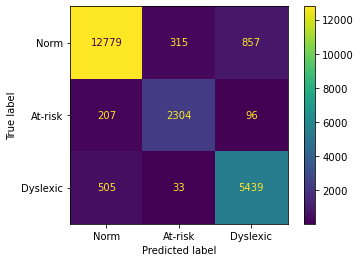

Kappa: 0.8347400437872468 AUC ROC: 0.9825072610728137


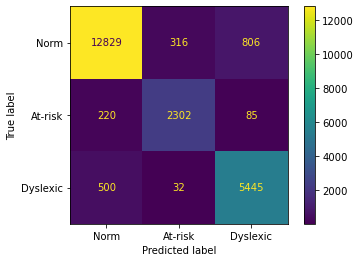

Kappa: 0.8388978522946917 AUC ROC: 0.9829182453627607


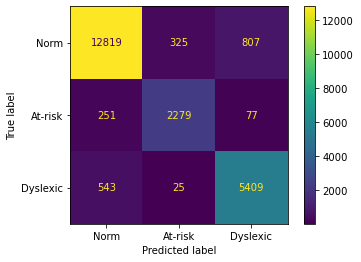

Kappa: 0.832869081391151 AUC ROC: 0.9823166765651608


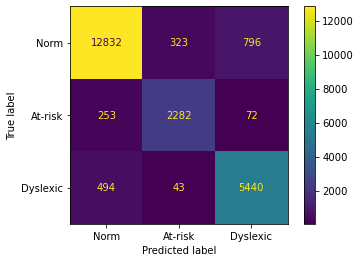

Kappa: 0.8369422822490217 AUC ROC: 0.9828148640073884


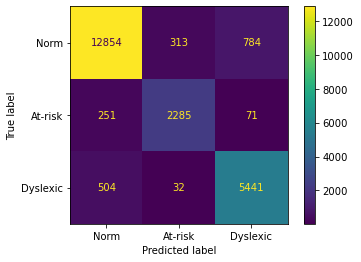

Kappa: 0.8389059114142479 AUC ROC: 0.9829848306845811


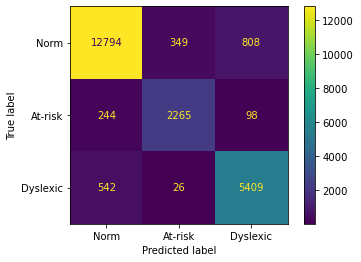

Kappa: 0.829841840423335 AUC ROC: 0.9823257928381303


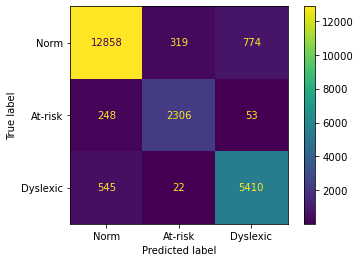

Kappa: 0.8382473045222396 AUC ROC: 0.9827749230027788


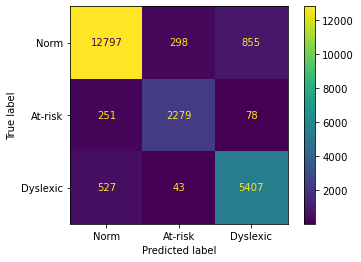

Kappa: 0.8310664313696852 AUC ROC: 0.9821932698756151


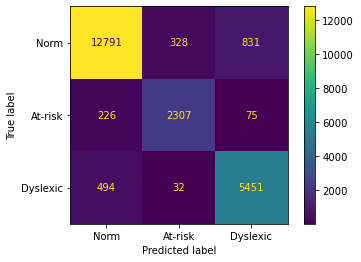

Kappa: 0.8368983636632326 AUC ROC: 0.9830666923198533


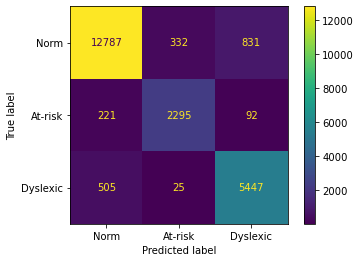

Kappa: 0.8352159256796329 AUC ROC: 0.9824885993933525


In [26]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )



for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    y_prob_ = results[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )





In [27]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)



  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.730 0.004 0.631 0.005 0.913 0.002 0.911 0.002 0.912 0.002 0.983 0.000 1.978 0.011 0.103 0.001 0.911 0.002 0.929 0.002


In [28]:


mdl.fit(x_train, y_train)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2689     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31344D+00    |proj g|=  3.97713D-01


 This problem is unconstrained.



At iterate    1    f=  1.20546D+00    |proj g|=  2.88565D-01

At iterate    2    f=  9.05287D-01    |proj g|=  7.83553D-02

At iterate    3    f=  8.75846D-01    |proj g|=  4.97868D-02

At iterate    4    f=  8.64406D-01    |proj g|=  2.37096D-02

At iterate    5    f=  8.40127D-01    |proj g|=  2.18697D-02

At iterate    6    f=  8.22142D-01    |proj g|=  2.71837D-02

At iterate    7    f=  8.09327D-01    |proj g|=  7.51927D-03

At iterate    8    f=  8.05735D-01    |proj g|=  5.56132D-03

At iterate    9    f=  8.01493D-01    |proj g|=  2.88072D-03

At iterate   10    f=  7.98401D-01    |proj g|=  4.98085D-03

At iterate   11    f=  7.94571D-01    |proj g|=  4.38217D-03

At iterate   12    f=  7.92512D-01    |proj g|=  2.70981D-03

At iterate   13    f=  7.91087D-01    |proj g|=  1.77570D-03

At iterate   14    f=  7.89198D-01    |proj g|=  2.05056D-03

At iterate   15    f=  7.87778D-01    |proj g|=  1.93737D-02

At iterate   16    f=  7.86337D-01    |proj g|=  5.24300D-03

At iter


At iterate  134    f=  6.63087D-01    |proj g|=  9.83591D-03

At iterate  135    f=  6.61409D-01    |proj g|=  9.86618D-03

At iterate  136    f=  6.60381D-01    |proj g|=  1.00698D-02

At iterate  137    f=  6.58708D-01    |proj g|=  1.08990D-02

At iterate  138    f=  6.58132D-01    |proj g|=  9.54971D-03

At iterate  139    f=  6.57466D-01    |proj g|=  5.84487D-03

At iterate  140    f=  6.56855D-01    |proj g|=  8.30617D-03

At iterate  141    f=  6.56608D-01    |proj g|=  1.86962D-02

At iterate  142    f=  6.55523D-01    |proj g|=  9.17325D-03

At iterate  143    f=  6.55181D-01    |proj g|=  5.24589D-03

At iterate  144    f=  6.54721D-01    |proj g|=  5.33071D-03

At iterate  145    f=  6.54142D-01    |proj g|=  7.49698D-03

At iterate  146    f=  6.53806D-01    |proj g|=  8.39357D-03

At iterate  147    f=  6.53362D-01    |proj g|=  4.93819D-03

At iterate  148    f=  6.52384D-01    |proj g|=  1.44571D-02

At iterate  149    f=  6.51695D-01    |proj g|=  1.44029D-02

At iter


At iterate  267    f=  5.66837D-01    |proj g|=  1.01029D-02

At iterate  268    f=  5.66389D-01    |proj g|=  1.23582D-02

At iterate  269    f=  5.65996D-01    |proj g|=  4.78554D-03

At iterate  270    f=  5.65600D-01    |proj g|=  6.19173D-03

At iterate  271    f=  5.65341D-01    |proj g|=  6.80332D-03

At iterate  272    f=  5.64754D-01    |proj g|=  1.89458D-02

At iterate  273    f=  5.63981D-01    |proj g|=  8.10960D-03

At iterate  274    f=  5.63539D-01    |proj g|=  8.21933D-03

At iterate  275    f=  5.62713D-01    |proj g|=  8.55908D-03

At iterate  276    f=  5.62466D-01    |proj g|=  1.35442D-02

At iterate  277    f=  5.62098D-01    |proj g|=  6.00200D-03

At iterate  278    f=  5.61861D-01    |proj g|=  5.82428D-03

At iterate  279    f=  5.61589D-01    |proj g|=  5.75468D-03

At iterate  280    f=  5.61072D-01    |proj g|=  6.82317D-03

At iterate  281    f=  5.60670D-01    |proj g|=  9.57825D-03

At iterate  282    f=  5.60043D-01    |proj g|=  6.21299D-03

At iter


At iterate  400    f=  4.92271D-01    |proj g|=  5.71466D-03

At iterate  401    f=  4.91860D-01    |proj g|=  6.65333D-03

At iterate  402    f=  4.91599D-01    |proj g|=  1.41206D-02

At iterate  403    f=  4.91132D-01    |proj g|=  1.03998D-02

At iterate  404    f=  4.90622D-01    |proj g|=  6.22130D-03

At iterate  405    f=  4.90408D-01    |proj g|=  6.95872D-03

At iterate  406    f=  4.89975D-01    |proj g|=  9.10160D-03

At iterate  407    f=  4.89299D-01    |proj g|=  1.14170D-02

At iterate  408    f=  4.88713D-01    |proj g|=  1.61147D-02

At iterate  409    f=  4.87854D-01    |proj g|=  6.10197D-03

At iterate  410    f=  4.87350D-01    |proj g|=  6.50768D-03

At iterate  411    f=  4.86684D-01    |proj g|=  9.02844D-03

At iterate  412    f=  4.86406D-01    |proj g|=  1.48590D-02

At iterate  413    f=  4.85897D-01    |proj g|=  9.05912D-03

At iterate  414    f=  4.85169D-01    |proj g|=  8.12452D-03

At iterate  415    f=  4.84706D-01    |proj g|=  1.38374D-02

At iter


At iterate  533    f=  4.26811D-01    |proj g|=  5.02084D-03

At iterate  534    f=  4.26632D-01    |proj g|=  5.61946D-03

At iterate  535    f=  4.26314D-01    |proj g|=  4.66055D-03

At iterate  536    f=  4.25972D-01    |proj g|=  6.54822D-03

At iterate  537    f=  4.25696D-01    |proj g|=  7.70221D-03

At iterate  538    f=  4.25407D-01    |proj g|=  5.23546D-03

At iterate  539    f=  4.25150D-01    |proj g|=  5.79290D-03

At iterate  540    f=  4.24805D-01    |proj g|=  6.13245D-03

At iterate  541    f=  4.24546D-01    |proj g|=  8.60653D-03

At iterate  542    f=  4.24175D-01    |proj g|=  1.01105D-02

At iterate  543    f=  4.23905D-01    |proj g|=  7.31874D-03

At iterate  544    f=  4.23605D-01    |proj g|=  1.67910D-02

At iterate  545    f=  4.23216D-01    |proj g|=  9.54386D-03

At iterate  546    f=  4.22808D-01    |proj g|=  5.35825D-03

At iterate  547    f=  4.22553D-01    |proj g|=  4.67080D-03

At iterate  548    f=  4.22262D-01    |proj g|=  5.46962D-03

At iter


At iterate  666    f=  3.81253D-01    |proj g|=  9.10868D-03

At iterate  667    f=  3.80736D-01    |proj g|=  5.49493D-03

At iterate  668    f=  3.80269D-01    |proj g|=  6.25874D-03

At iterate  669    f=  3.79891D-01    |proj g|=  1.33480D-02

At iterate  670    f=  3.79417D-01    |proj g|=  7.49703D-03

At iterate  671    f=  3.78793D-01    |proj g|=  6.37239D-03

At iterate  672    f=  3.78235D-01    |proj g|=  7.20340D-03

At iterate  673    f=  3.78065D-01    |proj g|=  3.17394D-02

At iterate  674    f=  3.77201D-01    |proj g|=  7.97852D-03

At iterate  675    f=  3.76975D-01    |proj g|=  7.25465D-03

At iterate  676    f=  3.76563D-01    |proj g|=  8.81120D-03

At iterate  677    f=  3.76437D-01    |proj g|=  6.82079D-03

At iterate  678    f=  3.76291D-01    |proj g|=  6.45239D-03

At iterate  679    f=  3.75692D-01    |proj g|=  5.35319D-03

At iterate  680    f=  3.75160D-01    |proj g|=  6.76857D-03

At iterate  681    f=  3.74978D-01    |proj g|=  2.10278D-02

At iter


At iterate  799    f=  3.36809D-01    |proj g|=  6.87599D-03

At iterate  800    f=  3.36602D-01    |proj g|=  5.92543D-03

At iterate  801    f=  3.36135D-01    |proj g|=  6.59422D-03

At iterate  802    f=  3.35937D-01    |proj g|=  1.64667D-02

At iterate  803    f=  3.35506D-01    |proj g|=  1.02141D-02

At iterate  804    f=  3.35230D-01    |proj g|=  7.72249D-03

At iterate  805    f=  3.34959D-01    |proj g|=  8.41487D-03

At iterate  806    f=  3.34480D-01    |proj g|=  9.15332D-03

At iterate  807    f=  3.34149D-01    |proj g|=  1.09617D-02

At iterate  808    f=  3.33689D-01    |proj g|=  5.07276D-03

At iterate  809    f=  3.33428D-01    |proj g|=  4.31113D-03

At iterate  810    f=  3.33277D-01    |proj g|=  2.47111D-02

At iterate  811    f=  3.32949D-01    |proj g|=  7.03569D-03

At iterate  812    f=  3.32780D-01    |proj g|=  6.19292D-03

At iterate  813    f=  3.32447D-01    |proj g|=  6.15347D-03

At iterate  814    f=  3.32047D-01    |proj g|=  8.85670D-03

At iter


At iterate  932    f=  2.96928D-01    |proj g|=  6.86168D-03

At iterate  933    f=  2.96794D-01    |proj g|=  5.06584D-03

At iterate  934    f=  2.96528D-01    |proj g|=  4.10625D-03

At iterate  935    f=  2.96346D-01    |proj g|=  4.09819D-03

At iterate  936    f=  2.96235D-01    |proj g|=  1.22931D-02

At iterate  937    f=  2.95979D-01    |proj g|=  6.08084D-03

At iterate  938    f=  2.95821D-01    |proj g|=  5.10975D-03

At iterate  939    f=  2.95448D-01    |proj g|=  6.13810D-03

At iterate  940    f=  2.95183D-01    |proj g|=  6.56387D-03

At iterate  941    f=  2.94998D-01    |proj g|=  1.22247D-02

At iterate  942    f=  2.94724D-01    |proj g|=  5.34655D-03

At iterate  943    f=  2.94596D-01    |proj g|=  4.64476D-03

At iterate  944    f=  2.94441D-01    |proj g|=  1.12459D-02

At iterate  945    f=  2.94273D-01    |proj g|=  4.80676D-03

At iterate  946    f=  2.94088D-01    |proj g|=  4.52819D-03

At iterate  947    f=  2.93896D-01    |proj g|=  8.61196D-03

At iter


At iterate 1065    f=  2.79524D-01    |proj g|=  1.06055D-02

At iterate 1066    f=  2.79365D-01    |proj g|=  4.42430D-03

At iterate 1067    f=  2.79255D-01    |proj g|=  3.21034D-03

At iterate 1068    f=  2.79164D-01    |proj g|=  4.45266D-03

At iterate 1069    f=  2.79126D-01    |proj g|=  1.17868D-02

At iterate 1070    f=  2.79021D-01    |proj g|=  4.13762D-03

At iterate 1071    f=  2.78948D-01    |proj g|=  4.84290D-03

At iterate 1072    f=  2.78859D-01    |proj g|=  5.27056D-03

At iterate 1073    f=  2.78777D-01    |proj g|=  1.83645D-02

At iterate 1074    f=  2.78626D-01    |proj g|=  7.03012D-03

At iterate 1075    f=  2.78515D-01    |proj g|=  5.27493D-03

At iterate 1076    f=  2.78426D-01    |proj g|=  5.89757D-03

At iterate 1077    f=  2.78287D-01    |proj g|=  5.46116D-03

At iterate 1078    f=  2.78097D-01    |proj g|=  1.00234D-02

At iterate 1079    f=  2.77919D-01    |proj g|=  7.42761D-03

At iterate 1080    f=  2.77810D-01    |proj g|=  3.61364D-03

At iter


At iterate 1198    f=  2.61275D-01    |proj g|=  8.57606D-03

At iterate 1199    f=  2.61196D-01    |proj g|=  8.06095D-03

At iterate 1200    f=  2.61014D-01    |proj g|=  7.00742D-03

At iterate 1201    f=  2.60700D-01    |proj g|=  6.06770D-03

At iterate 1202    f=  2.60593D-01    |proj g|=  1.01969D-02

At iterate 1203    f=  2.60444D-01    |proj g|=  4.38978D-03

At iterate 1204    f=  2.60346D-01    |proj g|=  4.08015D-03

At iterate 1205    f=  2.60220D-01    |proj g|=  4.79265D-03

At iterate 1206    f=  2.60000D-01    |proj g|=  5.76716D-03

At iterate 1207    f=  2.59638D-01    |proj g|=  6.97665D-03

At iterate 1208    f=  2.59455D-01    |proj g|=  6.07168D-03

At iterate 1209    f=  2.59220D-01    |proj g|=  5.17317D-03

At iterate 1210    f=  2.59176D-01    |proj g|=  1.75580D-02

At iterate 1211    f=  2.58978D-01    |proj g|=  4.54743D-03

At iterate 1212    f=  2.58905D-01    |proj g|=  4.49273D-03

At iterate 1213    f=  2.58724D-01    |proj g|=  7.94883D-03

At iter


At iterate 1331    f=  2.42188D-01    |proj g|=  1.11025D-02

At iterate 1332    f=  2.41916D-01    |proj g|=  4.31815D-03

At iterate 1333    f=  2.41779D-01    |proj g|=  3.59653D-03

At iterate 1334    f=  2.41661D-01    |proj g|=  8.07458D-03

At iterate 1335    f=  2.41636D-01    |proj g|=  1.31994D-02

At iterate 1336    f=  2.41511D-01    |proj g|=  4.36615D-03

At iterate 1337    f=  2.41448D-01    |proj g|=  3.89503D-03

At iterate 1338    f=  2.41378D-01    |proj g|=  4.39068D-03

At iterate 1339    f=  2.41303D-01    |proj g|=  3.67066D-03

At iterate 1340    f=  2.41246D-01    |proj g|=  9.53829D-03

At iterate 1341    f=  2.41106D-01    |proj g|=  4.31079D-03

At iterate 1342    f=  2.41030D-01    |proj g|=  5.27850D-03

At iterate 1343    f=  2.40921D-01    |proj g|=  5.17378D-03

At iterate 1344    f=  2.40754D-01    |proj g|=  6.63080D-03

At iterate 1345    f=  2.40583D-01    |proj g|=  6.99773D-03

At iterate 1346    f=  2.40426D-01    |proj g|=  4.23825D-03

At iter


At iterate 1464    f=  2.29183D-01    |proj g|=  2.74527D-03

At iterate 1465    f=  2.29068D-01    |proj g|=  6.62454D-03

At iterate 1466    f=  2.28951D-01    |proj g|=  4.37916D-03

At iterate 1467    f=  2.28889D-01    |proj g|=  2.70904D-03

At iterate 1468    f=  2.28828D-01    |proj g|=  2.47601D-03

At iterate 1469    f=  2.28784D-01    |proj g|=  8.26577D-03

At iterate 1470    f=  2.28711D-01    |proj g|=  3.20808D-03

At iterate 1471    f=  2.28667D-01    |proj g|=  3.59180D-03

At iterate 1472    f=  2.28597D-01    |proj g|=  2.98362D-03

At iterate 1473    f=  2.28532D-01    |proj g|=  4.98668D-03

At iterate 1474    f=  2.28448D-01    |proj g|=  5.23273D-03

At iterate 1475    f=  2.28374D-01    |proj g|=  4.41699D-03

At iterate 1476    f=  2.28320D-01    |proj g|=  3.13861D-03

At iterate 1477    f=  2.28236D-01    |proj g|=  2.66853D-03

At iterate 1478    f=  2.28124D-01    |proj g|=  2.98010D-03

At iterate 1479    f=  2.28038D-01    |proj g|=  3.18419D-03

At iter


At iterate 1597    f=  2.21918D-01    |proj g|=  1.79862D-03

At iterate 1598    f=  2.21888D-01    |proj g|=  2.15110D-03

At iterate 1599    f=  2.21878D-01    |proj g|=  6.62199D-03

At iterate 1600    f=  2.21854D-01    |proj g|=  3.06731D-03

At iterate 1601    f=  2.21841D-01    |proj g|=  2.47715D-03

At iterate 1602    f=  2.21821D-01    |proj g|=  2.02046D-03

At iterate 1603    f=  2.21797D-01    |proj g|=  2.04826D-03

At iterate 1604    f=  2.21766D-01    |proj g|=  2.34840D-03

At iterate 1605    f=  2.21756D-01    |proj g|=  5.81390D-03

At iterate 1606    f=  2.21725D-01    |proj g|=  2.16190D-03

At iterate 1607    f=  2.21704D-01    |proj g|=  1.17432D-03

At iterate 1608    f=  2.21683D-01    |proj g|=  2.43377D-03

At iterate 1609    f=  2.21652D-01    |proj g|=  2.66970D-03

At iterate 1610    f=  2.21635D-01    |proj g|=  6.77321D-03

At iterate 1611    f=  2.21574D-01    |proj g|=  1.84047D-03

At iterate 1612    f=  2.21554D-01    |proj g|=  1.33778D-03

At iter


At iterate 1730    f=  2.18869D-01    |proj g|=  1.36915D-03

At iterate 1731    f=  2.18839D-01    |proj g|=  2.12847D-03

At iterate 1732    f=  2.18811D-01    |proj g|=  8.68248D-03

At iterate 1733    f=  2.18777D-01    |proj g|=  3.30064D-03

At iterate 1734    f=  2.18758D-01    |proj g|=  1.79400D-03

At iterate 1735    f=  2.18739D-01    |proj g|=  1.88810D-03

At iterate 1736    f=  2.18718D-01    |proj g|=  2.92772D-03

At iterate 1737    f=  2.18687D-01    |proj g|=  2.53618D-03

At iterate 1738    f=  2.18615D-01    |proj g|=  3.89541D-03

At iterate 1739    f=  2.18588D-01    |proj g|=  3.90887D-03

At iterate 1740    f=  2.18570D-01    |proj g|=  1.81525D-03

At iterate 1741    f=  2.18552D-01    |proj g|=  1.62122D-03

At iterate 1742    f=  2.18531D-01    |proj g|=  2.10439D-03

At iterate 1743    f=  2.18497D-01    |proj g|=  2.40839D-03

At iterate 1744    f=  2.18481D-01    |proj g|=  6.13590D-03

At iterate 1745    f=  2.18450D-01    |proj g|=  2.29358D-03

At iter


At iterate 1863    f=  2.16252D-01    |proj g|=  3.89180D-03

At iterate 1864    f=  2.16237D-01    |proj g|=  1.23903D-03

At iterate 1865    f=  2.16230D-01    |proj g|=  1.13316D-03

At iterate 1866    f=  2.16216D-01    |proj g|=  1.66414D-03

At iterate 1867    f=  2.16198D-01    |proj g|=  2.31255D-03

At iterate 1868    f=  2.16191D-01    |proj g|=  1.65826D-03

At iterate 1869    f=  2.16182D-01    |proj g|=  1.02230D-03

At iterate 1870    f=  2.16176D-01    |proj g|=  1.13476D-03

At iterate 1871    f=  2.16170D-01    |proj g|=  3.92660D-03

At iterate 1872    f=  2.16162D-01    |proj g|=  2.16676D-03

At iterate 1873    f=  2.16152D-01    |proj g|=  1.19790D-03

At iterate 1874    f=  2.16144D-01    |proj g|=  1.26321D-03

At iterate 1875    f=  2.16135D-01    |proj g|=  1.44988D-03

At iterate 1876    f=  2.16120D-01    |proj g|=  2.11853D-03

At iterate 1877    f=  2.16109D-01    |proj g|=  1.88812D-03

At iterate 1878    f=  2.16096D-01    |proj g|=  1.46813D-03

At iter


At iterate 1996    f=  2.14804D-01    |proj g|=  4.51861D-03

At iterate 1997    f=  2.14783D-01    |proj g|=  1.47917D-03

At iterate 1998    f=  2.14773D-01    |proj g|=  1.20315D-03

At iterate 1999    f=  2.14762D-01    |proj g|=  1.54568D-03

At iterate 2000    f=  2.14751D-01    |proj g|=  2.24903D-03

At iterate 2001    f=  2.14736D-01    |proj g|=  1.37526D-03

At iterate 2002    f=  2.14719D-01    |proj g|=  1.02800D-03

At iterate 2003    f=  2.14702D-01    |proj g|=  2.41497D-03

At iterate 2004    f=  2.14683D-01    |proj g|=  1.88317D-03

At iterate 2005    f=  2.14668D-01    |proj g|=  1.73224D-03

At iterate 2006    f=  2.14635D-01    |proj g|=  2.56576D-03

At iterate 2007    f=  2.14628D-01    |proj g|=  2.19774D-03

At iterate 2008    f=  2.14619D-01    |proj g|=  1.73493D-03

At iterate 2009    f=  2.14605D-01    |proj g|=  1.34858D-03

At iterate 2010    f=  2.14587D-01    |proj g|=  2.43864D-03

At iterate 2011    f=  2.14584D-01    |proj g|=  3.58926D-03

At iter


At iterate 2129    f=  2.12919D-01    |proj g|=  1.96643D-03

At iterate 2130    f=  2.12905D-01    |proj g|=  2.75976D-03

At iterate 2131    f=  2.12872D-01    |proj g|=  2.90166D-03

At iterate 2132    f=  2.12852D-01    |proj g|=  4.33162D-03

At iterate 2133    f=  2.12824D-01    |proj g|=  2.20466D-03

At iterate 2134    f=  2.12798D-01    |proj g|=  1.78306D-03

At iterate 2135    f=  2.12768D-01    |proj g|=  2.80293D-03

At iterate 2136    f=  2.12754D-01    |proj g|=  6.86171D-03

At iterate 2137    f=  2.12724D-01    |proj g|=  2.20421D-03

At iterate 2138    f=  2.12712D-01    |proj g|=  1.31140D-03

At iterate 2139    f=  2.12700D-01    |proj g|=  2.51934D-03

At iterate 2140    f=  2.12693D-01    |proj g|=  6.93174D-03

At iterate 2141    f=  2.12679D-01    |proj g|=  3.46993D-03

At iterate 2142    f=  2.12662D-01    |proj g|=  1.89816D-03

At iterate 2143    f=  2.12651D-01    |proj g|=  2.68660D-03

At iterate 2144    f=  2.12624D-01    |proj g|=  3.25896D-03

At iter


At iterate 2262    f=  2.10378D-01    |proj g|=  1.97689D-03

At iterate 2263    f=  2.10352D-01    |proj g|=  2.52975D-03

At iterate 2264    f=  2.10330D-01    |proj g|=  3.41681D-03

At iterate 2265    f=  2.10311D-01    |proj g|=  1.05112D-02

At iterate 2266    f=  2.10269D-01    |proj g|=  2.48839D-03

At iterate 2267    f=  2.10257D-01    |proj g|=  1.64210D-03

At iterate 2268    f=  2.10244D-01    |proj g|=  5.84404D-03

At iterate 2269    f=  2.10233D-01    |proj g|=  3.02560D-03

At iterate 2270    f=  2.10224D-01    |proj g|=  2.29977D-03

At iterate 2271    f=  2.10195D-01    |proj g|=  1.39469D-03

At iterate 2272    f=  2.10178D-01    |proj g|=  1.35188D-03

At iterate 2273    f=  2.10154D-01    |proj g|=  7.10179D-03

At iterate 2274    f=  2.10117D-01    |proj g|=  1.63421D-03

At iterate 2275    f=  2.10103D-01    |proj g|=  1.10789D-03

At iterate 2276    f=  2.10081D-01    |proj g|=  1.66605D-03

At iterate 2277    f=  2.10055D-01    |proj g|=  2.92647D-03

At iter


At iterate 2517    f=  2.06406D-01    |proj g|=  2.99902D-03

At iterate 2518    f=  2.06389D-01    |proj g|=  3.71692D-03

At iterate 2519    f=  2.06371D-01    |proj g|=  3.63466D-03

At iterate 2520    f=  2.06353D-01    |proj g|=  2.29350D-03

At iterate 2521    f=  2.06341D-01    |proj g|=  2.72273D-03

At iterate 2522    f=  2.06331D-01    |proj g|=  2.58308D-03

At iterate 2523    f=  2.06320D-01    |proj g|=  2.29252D-03

At iterate 2524    f=  2.06304D-01    |proj g|=  2.51640D-03

At iterate 2525    f=  2.06289D-01    |proj g|=  2.68314D-03

At iterate 2526    f=  2.06274D-01    |proj g|=  2.82496D-03

At iterate 2527    f=  2.06249D-01    |proj g|=  1.73484D-03

At iterate 2528    f=  2.06229D-01    |proj g|=  4.10605D-03

At iterate 2529    f=  2.06206D-01    |proj g|=  2.55294D-03

At iterate 2530    f=  2.06187D-01    |proj g|=  2.61425D-03

At iterate 2531    f=  2.06166D-01    |proj g|=  5.57725D-03

At iterate 2532    f=  2.06148D-01    |proj g|=  2.03492D-03

At iter


At iterate 2650    f=  2.04044D-01    |proj g|=  2.69201D-03

At iterate 2651    f=  2.04016D-01    |proj g|=  2.23035D-03

At iterate 2652    f=  2.03989D-01    |proj g|=  4.72097D-03

At iterate 2653    f=  2.03963D-01    |proj g|=  2.98331D-03

At iterate 2654    f=  2.03943D-01    |proj g|=  2.47661D-03

At iterate 2655    f=  2.03917D-01    |proj g|=  2.56064D-03

At iterate 2656    f=  2.03877D-01    |proj g|=  4.27794D-03

At iterate 2657    f=  2.03867D-01    |proj g|=  9.02651D-03

At iterate 2658    f=  2.03841D-01    |proj g|=  2.35139D-03

At iterate 2659    f=  2.03835D-01    |proj g|=  1.92297D-03

At iterate 2660    f=  2.03822D-01    |proj g|=  2.35080D-03

At iterate 2661    f=  2.03797D-01    |proj g|=  3.48897D-03

At iterate 2662    f=  2.03786D-01    |proj g|=  6.13595D-03

At iterate 2663    f=  2.03764D-01    |proj g|=  2.94003D-03

At iterate 2664    f=  2.03746D-01    |proj g|=  1.67083D-03

At iterate 2665    f=  2.03726D-01    |proj g|=  2.62563D-03

At iter


At iterate 2783    f=  2.01142D-01    |proj g|=  2.92659D-03

At iterate 2784    f=  2.01130D-01    |proj g|=  4.76927D-03

At iterate 2785    f=  2.01114D-01    |proj g|=  2.06345D-03

At iterate 2786    f=  2.01096D-01    |proj g|=  1.91733D-03

At iterate 2787    f=  2.01078D-01    |proj g|=  2.85193D-03

At iterate 2788    f=  2.01044D-01    |proj g|=  2.73351D-03

At iterate 2789    f=  2.01034D-01    |proj g|=  1.03795D-02

At iterate 2790    f=  2.00984D-01    |proj g|=  2.95364D-03

At iterate 2791    f=  2.00969D-01    |proj g|=  1.61815D-03

At iterate 2792    f=  2.00953D-01    |proj g|=  2.33138D-03

At iterate 2793    f=  2.00932D-01    |proj g|=  2.55274D-03

At iterate 2794    f=  2.00916D-01    |proj g|=  4.07198D-03

At iterate 2795    f=  2.00885D-01    |proj g|=  2.57789D-03

At iterate 2796    f=  2.00872D-01    |proj g|=  6.69304D-03

At iterate 2797    f=  2.00852D-01    |proj g|=  1.59375D-03

At iterate 2798    f=  2.00838D-01    |proj g|=  1.66174D-03

At iter


At iterate 2916    f=  1.98638D-01    |proj g|=  2.67317D-03

At iterate 2917    f=  1.98621D-01    |proj g|=  3.05003D-03

At iterate 2918    f=  1.98611D-01    |proj g|=  5.31250D-03

At iterate 2919    f=  1.98591D-01    |proj g|=  2.17873D-03

At iterate 2920    f=  1.98578D-01    |proj g|=  2.45984D-03

At iterate 2921    f=  1.98567D-01    |proj g|=  4.28402D-03

At iterate 2922    f=  1.98556D-01    |proj g|=  2.22429D-03

At iterate 2923    f=  1.98550D-01    |proj g|=  1.95605D-03

At iterate 2924    f=  1.98541D-01    |proj g|=  1.74164D-03

At iterate 2925    f=  1.98526D-01    |proj g|=  1.83202D-03

At iterate 2926    f=  1.98512D-01    |proj g|=  5.58908D-03

At iterate 2927    f=  1.98494D-01    |proj g|=  1.52122D-03

At iterate 2928    f=  1.98482D-01    |proj g|=  1.55054D-03

At iterate 2929    f=  1.98464D-01    |proj g|=  3.60545D-03

At iterate 2930    f=  1.98444D-01    |proj g|=  3.63135D-03

At iterate 2931    f=  1.98422D-01    |proj g|=  1.44686D-03

At iter


At iterate 3049    f=  1.96818D-01    |proj g|=  1.08993D-03

At iterate 3050    f=  1.96813D-01    |proj g|=  1.26365D-03

At iterate 3051    f=  1.96802D-01    |proj g|=  1.81465D-03

At iterate 3052    f=  1.96783D-01    |proj g|=  3.03612D-03

At iterate 3053    f=  1.96773D-01    |proj g|=  4.41864D-03

At iterate 3054    f=  1.96762D-01    |proj g|=  1.82478D-03

At iterate 3055    f=  1.96755D-01    |proj g|=  1.73175D-03

At iterate 3056    f=  1.96749D-01    |proj g|=  1.84510D-03

At iterate 3057    f=  1.96727D-01    |proj g|=  5.39566D-03

At iterate 3058    f=  1.96717D-01    |proj g|=  6.31778D-03

At iterate 3059    f=  1.96699D-01    |proj g|=  2.17172D-03

At iterate 3060    f=  1.96689D-01    |proj g|=  1.37736D-03

At iterate 3061    f=  1.96679D-01    |proj g|=  2.14261D-03

At iterate 3062    f=  1.96671D-01    |proj g|=  2.10237D-03

At iterate 3063    f=  1.96664D-01    |proj g|=  1.30975D-03

At iterate 3064    f=  1.96657D-01    |proj g|=  1.31751D-03

At iter


At iterate 3182    f=  1.95528D-01    |proj g|=  2.68718D-03

At iterate 3183    f=  1.95523D-01    |proj g|=  2.05512D-03

At iterate 3184    f=  1.95516D-01    |proj g|=  1.02680D-03

At iterate 3185    f=  1.95513D-01    |proj g|=  2.56601D-03

At iterate 3186    f=  1.95509D-01    |proj g|=  1.12992D-03

At iterate 3187    f=  1.95506D-01    |proj g|=  1.23074D-03

At iterate 3188    f=  1.95500D-01    |proj g|=  1.50625D-03

At iterate 3189    f=  1.95492D-01    |proj g|=  1.39532D-03

At iterate 3190    f=  1.95488D-01    |proj g|=  2.94461D-03

At iterate 3191    f=  1.95482D-01    |proj g|=  1.99513D-03

At iterate 3192    f=  1.95477D-01    |proj g|=  1.15386D-03

At iterate 3193    f=  1.95471D-01    |proj g|=  2.80034D-03

At iterate 3194    f=  1.95464D-01    |proj g|=  1.99375D-03

At iterate 3195    f=  1.95451D-01    |proj g|=  1.73355D-03

At iterate 3196    f=  1.95443D-01    |proj g|=  5.31778D-03

At iterate 3197    f=  1.95434D-01    |proj g|=  1.81434D-03

At iter


At iterate 3315    f=  1.94643D-01    |proj g|=  4.24666D-03

At iterate 3316    f=  1.94635D-01    |proj g|=  1.89382D-03

At iterate 3317    f=  1.94630D-01    |proj g|=  1.21728D-03

At iterate 3318    f=  1.94624D-01    |proj g|=  1.45905D-03

At iterate 3319    f=  1.94622D-01    |proj g|=  3.30720D-03

At iterate 3320    f=  1.94619D-01    |proj g|=  2.14407D-03

At iterate 3321    f=  1.94609D-01    |proj g|=  1.42774D-03

At iterate 3322    f=  1.94605D-01    |proj g|=  1.04645D-03

At iterate 3323    f=  1.94599D-01    |proj g|=  1.47072D-03

At iterate 3324    f=  1.94590D-01    |proj g|=  2.74520D-03

At iterate 3325    f=  1.94582D-01    |proj g|=  1.58477D-03

At iterate 3326    f=  1.94573D-01    |proj g|=  1.33818D-03

At iterate 3327    f=  1.94564D-01    |proj g|=  1.59446D-03

At iterate 3328    f=  1.94556D-01    |proj g|=  1.94619D-03

At iterate 3329    f=  1.94549D-01    |proj g|=  1.61071D-03

At iterate 3330    f=  1.94544D-01    |proj g|=  1.18641D-03

At iter


At iterate 3448    f=  1.93674D-01    |proj g|=  5.50533D-03

At iterate 3449    f=  1.93668D-01    |proj g|=  1.16653D-03

At iterate 3450    f=  1.93665D-01    |proj g|=  1.20502D-03

At iterate 3451    f=  1.93658D-01    |proj g|=  1.16047D-03

At iterate 3452    f=  1.93652D-01    |proj g|=  1.23643D-03

At iterate 3453    f=  1.93648D-01    |proj g|=  5.92011D-03

At iterate 3454    f=  1.93635D-01    |proj g|=  1.44029D-03

At iterate 3455    f=  1.93633D-01    |proj g|=  9.66987D-04

At iterate 3456    f=  1.93628D-01    |proj g|=  7.30328D-04

At iterate 3457    f=  1.93621D-01    |proj g|=  3.38468D-03

At iterate 3458    f=  1.93613D-01    |proj g|=  1.20571D-03

At iterate 3459    f=  1.93606D-01    |proj g|=  1.12980D-03

At iterate 3460    f=  1.93603D-01    |proj g|=  7.44311D-03

At iterate 3461    f=  1.93592D-01    |proj g|=  2.80822D-03

At iterate 3462    f=  1.93589D-01    |proj g|=  1.67871D-03

At iterate 3463    f=  1.93581D-01    |proj g|=  1.32950D-03

At iter


At iterate 3581    f=  1.92749D-01    |proj g|=  1.66763D-03

At iterate 3582    f=  1.92747D-01    |proj g|=  3.78053D-03

At iterate 3583    f=  1.92735D-01    |proj g|=  1.43011D-03

At iterate 3584    f=  1.92730D-01    |proj g|=  9.00938D-04

At iterate 3585    f=  1.92726D-01    |proj g|=  2.73032D-03

At iterate 3586    f=  1.92722D-01    |proj g|=  1.20122D-03

At iterate 3587    f=  1.92719D-01    |proj g|=  1.16120D-03

At iterate 3588    f=  1.92713D-01    |proj g|=  1.58279D-03

At iterate 3589    f=  1.92708D-01    |proj g|=  1.63540D-03

At iterate 3590    f=  1.92702D-01    |proj g|=  2.62544D-03

At iterate 3591    f=  1.92695D-01    |proj g|=  1.13651D-03

At iterate 3592    f=  1.92690D-01    |proj g|=  1.65959D-03

At iterate 3593    f=  1.92682D-01    |proj g|=  1.63207D-03

At iterate 3594    f=  1.92669D-01    |proj g|=  3.79647D-03

At iterate 3595    f=  1.92665D-01    |proj g|=  3.13004D-03

At iterate 3596    f=  1.92657D-01    |proj g|=  8.49601D-04

At iter


At iterate 3714    f=  1.92051D-01    |proj g|=  2.52038D-03

At iterate 3715    f=  1.92046D-01    |proj g|=  1.77387D-03

At iterate 3716    f=  1.92042D-01    |proj g|=  1.20550D-03

At iterate 3717    f=  1.92036D-01    |proj g|=  1.09918D-03

At iterate 3718    f=  1.92032D-01    |proj g|=  3.10547D-03

At iterate 3719    f=  1.92026D-01    |proj g|=  1.00069D-03

At iterate 3720    f=  1.92022D-01    |proj g|=  1.32591D-03

At iterate 3721    f=  1.92016D-01    |proj g|=  1.81898D-03

At iterate 3722    f=  1.92013D-01    |proj g|=  2.72015D-03

At iterate 3723    f=  1.92009D-01    |proj g|=  1.58704D-03

At iterate 3724    f=  1.92006D-01    |proj g|=  9.01840D-04

At iterate 3725    f=  1.92001D-01    |proj g|=  2.89157D-03

At iterate 3726    f=  1.91997D-01    |proj g|=  1.52949D-03

At iterate 3727    f=  1.91994D-01    |proj g|=  9.75939D-04

At iterate 3728    f=  1.91989D-01    |proj g|=  1.33803D-03

At iterate 3729    f=  1.91983D-01    |proj g|=  1.74414D-03

At iter


At iterate 3847    f=  1.91493D-01    |proj g|=  1.14153D-03

At iterate 3848    f=  1.91487D-01    |proj g|=  1.77949D-03

At iterate 3849    f=  1.91484D-01    |proj g|=  1.88242D-03

At iterate 3850    f=  1.91480D-01    |proj g|=  7.64277D-04

At iterate 3851    f=  1.91478D-01    |proj g|=  7.60341D-04

At iterate 3852    f=  1.91475D-01    |proj g|=  2.54088D-03

At iterate 3853    f=  1.91471D-01    |proj g|=  1.18083D-03

At iterate 3854    f=  1.91468D-01    |proj g|=  1.00377D-03

At iterate 3855    f=  1.91462D-01    |proj g|=  1.83367D-03

At iterate 3856    f=  1.91458D-01    |proj g|=  1.22451D-03

At iterate 3857    f=  1.91454D-01    |proj g|=  1.91521D-03

At iterate 3858    f=  1.91450D-01    |proj g|=  1.14472D-03

At iterate 3859    f=  1.91447D-01    |proj g|=  9.47636D-04

At iterate 3860    f=  1.91443D-01    |proj g|=  9.82909D-04

At iterate 3861    f=  1.91438D-01    |proj g|=  1.82459D-03

At iterate 3862    f=  1.91433D-01    |proj g|=  1.22319D-03

At iter


At iterate 3980    f=  1.91105D-01    |proj g|=  9.00386D-04

At iterate 3981    f=  1.91101D-01    |proj g|=  1.72886D-03

At iterate 3982    f=  1.91097D-01    |proj g|=  2.57059D-03

At iterate 3983    f=  1.91094D-01    |proj g|=  1.36648D-03

At iterate 3984    f=  1.91090D-01    |proj g|=  7.58719D-04

At iterate 3985    f=  1.91089D-01    |proj g|=  1.75968D-03

At iterate 3986    f=  1.91086D-01    |proj g|=  1.02084D-03

At iterate 3987    f=  1.91081D-01    |proj g|=  7.36485D-04

At iterate 3988    f=  1.91079D-01    |proj g|=  2.01830D-03

At iterate 3989    f=  1.91078D-01    |proj g|=  1.42504D-03

At iterate 3990    f=  1.91076D-01    |proj g|=  6.05841D-04

At iterate 3991    f=  1.91074D-01    |proj g|=  9.53683D-04

At iterate 3992    f=  1.91070D-01    |proj g|=  1.26388D-03

At iterate 3993    f=  1.91068D-01    |proj g|=  1.56776D-03

At iterate 3994    f=  1.91065D-01    |proj g|=  5.05520D-04

At iterate 3995    f=  1.91064D-01    |proj g|=  8.38905D-04

At iter


At iterate 4113    f=  1.90664D-01    |proj g|=  9.25744D-04

At iterate 4114    f=  1.90662D-01    |proj g|=  5.38597D-04

At iterate 4115    f=  1.90659D-01    |proj g|=  9.37840D-04

At iterate 4116    f=  1.90658D-01    |proj g|=  2.51615D-03

At iterate 4117    f=  1.90655D-01    |proj g|=  1.09405D-03

At iterate 4118    f=  1.90653D-01    |proj g|=  5.22633D-04

At iterate 4119    f=  1.90652D-01    |proj g|=  7.17354D-04

At iterate 4120    f=  1.90649D-01    |proj g|=  6.93941D-04

At iterate 4121    f=  1.90647D-01    |proj g|=  2.16923D-03

At iterate 4122    f=  1.90644D-01    |proj g|=  1.07979D-03

At iterate 4123    f=  1.90642D-01    |proj g|=  8.13792D-04

At iterate 4124    f=  1.90641D-01    |proj g|=  2.80236D-03

At iterate 4125    f=  1.90638D-01    |proj g|=  1.28508D-03

At iterate 4126    f=  1.90636D-01    |proj g|=  8.15941D-04

At iterate 4127    f=  1.90634D-01    |proj g|=  1.27127D-03

At iterate 4128    f=  1.90631D-01    |proj g|=  1.32543D-03

At iter


At iterate 4246    f=  1.90304D-01    |proj g|=  9.46166D-04

At iterate 4247    f=  1.90301D-01    |proj g|=  1.05619D-03

At iterate 4248    f=  1.90299D-01    |proj g|=  1.25145D-03

At iterate 4249    f=  1.90297D-01    |proj g|=  3.59465D-03

At iterate 4250    f=  1.90292D-01    |proj g|=  7.56425D-04

At iterate 4251    f=  1.90290D-01    |proj g|=  9.52944D-04

At iterate 4252    f=  1.90286D-01    |proj g|=  1.02506D-03

At iterate 4253    f=  1.90281D-01    |proj g|=  3.16250D-03

At iterate 4254    f=  1.90277D-01    |proj g|=  2.05096D-03

At iterate 4255    f=  1.90274D-01    |proj g|=  8.77615D-04

At iterate 4256    f=  1.90272D-01    |proj g|=  7.26109D-04

At iterate 4257    f=  1.90270D-01    |proj g|=  8.04176D-04

At iterate 4258    f=  1.90263D-01    |proj g|=  1.06857D-03

At iterate 4259    f=  1.90261D-01    |proj g|=  2.06682D-03

At iterate 4260    f=  1.90257D-01    |proj g|=  8.74160D-04

At iterate 4261    f=  1.90254D-01    |proj g|=  7.32627D-04

At iter


At iterate 4379    f=  1.89866D-01    |proj g|=  9.37045D-04

At iterate 4380    f=  1.89863D-01    |proj g|=  8.42882D-04

At iterate 4381    f=  1.89858D-01    |proj g|=  1.12887D-03

At iterate 4382    f=  1.89857D-01    |proj g|=  3.60324D-03

At iterate 4383    f=  1.89850D-01    |proj g|=  1.13581D-03

At iterate 4384    f=  1.89848D-01    |proj g|=  7.29228D-04

At iterate 4385    f=  1.89846D-01    |proj g|=  8.59701D-04

At iterate 4386    f=  1.89843D-01    |proj g|=  3.28542D-03

At iterate 4387    f=  1.89840D-01    |proj g|=  1.69432D-03

At iterate 4388    f=  1.89836D-01    |proj g|=  9.13755D-04

At iterate 4389    f=  1.89834D-01    |proj g|=  1.97387D-03

At iterate 4390    f=  1.89831D-01    |proj g|=  2.03258D-03

At iterate 4391    f=  1.89825D-01    |proj g|=  2.34349D-03

At iterate 4392    f=  1.89822D-01    |proj g|=  3.68211D-03

At iterate 4393    f=  1.89816D-01    |proj g|=  1.11927D-03

At iterate 4394    f=  1.89814D-01    |proj g|=  6.83845D-04

At iter


At iterate 4512    f=  1.89546D-01    |proj g|=  5.89252D-04

At iterate 4513    f=  1.89544D-01    |proj g|=  5.11319D-04

At iterate 4514    f=  1.89543D-01    |proj g|=  1.67189D-03

At iterate 4515    f=  1.89542D-01    |proj g|=  8.21757D-04

At iterate 4516    f=  1.89541D-01    |proj g|=  3.98480D-04

At iterate 4517    f=  1.89539D-01    |proj g|=  9.29733D-04

At iterate 4518    f=  1.89537D-01    |proj g|=  8.03959D-04

At iterate 4519    f=  1.89536D-01    |proj g|=  2.63227D-03

At iterate 4520    f=  1.89534D-01    |proj g|=  8.36735D-04

At iterate 4521    f=  1.89533D-01    |proj g|=  5.97057D-04

At iterate 4522    f=  1.89532D-01    |proj g|=  6.96854D-04

At iterate 4523    f=  1.89531D-01    |proj g|=  1.38540D-03

At iterate 4524    f=  1.89530D-01    |proj g|=  1.06928D-03

At iterate 4525    f=  1.89528D-01    |proj g|=  8.16280D-04

At iterate 4526    f=  1.89527D-01    |proj g|=  6.53329D-04

At iterate 4527    f=  1.89526D-01    |proj g|=  1.43668D-03

At iter


At iterate 4645    f=  1.89374D-01    |proj g|=  1.26918D-03

At iterate 4646    f=  1.89371D-01    |proj g|=  9.86411D-04

At iterate 4647    f=  1.89369D-01    |proj g|=  8.87271D-04

At iterate 4648    f=  1.89368D-01    |proj g|=  1.43581D-03

At iterate 4649    f=  1.89367D-01    |proj g|=  9.77792D-04

At iterate 4650    f=  1.89366D-01    |proj g|=  7.40473D-04

At iterate 4651    f=  1.89362D-01    |proj g|=  6.47840D-04

At iterate 4652    f=  1.89359D-01    |proj g|=  1.01005D-03

At iterate 4653    f=  1.89356D-01    |proj g|=  9.09534D-04

At iterate 4654    f=  1.89354D-01    |proj g|=  4.99228D-04

At iterate 4655    f=  1.89353D-01    |proj g|=  6.33990D-04

At iterate 4656    f=  1.89351D-01    |proj g|=  7.84607D-04

At iterate 4657    f=  1.89349D-01    |proj g|=  8.79732D-04

At iterate 4658    f=  1.89347D-01    |proj g|=  1.28355D-03

At iterate 4659    f=  1.89346D-01    |proj g|=  9.49328D-04

At iterate 4660    f=  1.89346D-01    |proj g|=  8.39953D-04

At iter


At iterate 4835    f=  1.89118D-01    |proj g|=  4.02023D-04

At iterate 4836    f=  1.89117D-01    |proj g|=  6.04326D-04

At iterate 4837    f=  1.89116D-01    |proj g|=  7.88467D-04

At iterate 4838    f=  1.89114D-01    |proj g|=  6.41881D-04

At iterate 4839    f=  1.89113D-01    |proj g|=  1.80463D-03

At iterate 4840    f=  1.89110D-01    |proj g|=  6.32759D-04

At iterate 4841    f=  1.89109D-01    |proj g|=  9.13443D-04

At iterate 4842    f=  1.89108D-01    |proj g|=  9.08758D-04

At iterate 4843    f=  1.89106D-01    |proj g|=  2.15698D-03

At iterate 4844    f=  1.89104D-01    |proj g|=  1.04230D-03

At iterate 4845    f=  1.89102D-01    |proj g|=  6.87661D-04

At iterate 4846    f=  1.89100D-01    |proj g|=  1.08659D-03

At iterate 4847    f=  1.89098D-01    |proj g|=  1.64933D-03

At iterate 4848    f=  1.89096D-01    |proj g|=  1.56552D-03

At iterate 4849    f=  1.89095D-01    |proj g|=  8.72397D-04

At iterate 4850    f=  1.89093D-01    |proj g|=  9.04090D-04

At iter


At iterate 4968    f=  1.88885D-01    |proj g|=  2.65559D-03

At iterate 4969    f=  1.88883D-01    |proj g|=  8.66817D-04

At iterate 4970    f=  1.88882D-01    |proj g|=  5.60272D-04

At iterate 4971    f=  1.88881D-01    |proj g|=  6.66884D-04

At iterate 4972    f=  1.88880D-01    |proj g|=  2.20177D-03

At iterate 4973    f=  1.88878D-01    |proj g|=  1.07835D-03

At iterate 4974    f=  1.88877D-01    |proj g|=  5.02310D-04

At iterate 4975    f=  1.88876D-01    |proj g|=  5.24228D-04

At iterate 4976    f=  1.88875D-01    |proj g|=  4.74117D-04

At iterate 4977    f=  1.88873D-01    |proj g|=  1.49512D-03

At iterate 4978    f=  1.88872D-01    |proj g|=  2.15454D-03

At iterate 4979    f=  1.88870D-01    |proj g|=  3.73642D-04

At iterate 4980    f=  1.88869D-01    |proj g|=  7.33763D-04

At iterate 4981    f=  1.88868D-01    |proj g|=  9.94402D-04

At iterate 4982    f=  1.88866D-01    |proj g|=  1.08339D-03

At iterate 4983    f=  1.88864D-01    |proj g|=  5.98992D-04

At iter


At iterate 5101    f=  1.88642D-01    |proj g|=  1.69741D-03

At iterate 5102    f=  1.88638D-01    |proj g|=  1.26604D-03

At iterate 5103    f=  1.88634D-01    |proj g|=  8.23395D-04

At iterate 5104    f=  1.88631D-01    |proj g|=  7.78360D-04

At iterate 5105    f=  1.88629D-01    |proj g|=  2.64539D-03

At iterate 5106    f=  1.88625D-01    |proj g|=  1.46623D-03

At iterate 5107    f=  1.88624D-01    |proj g|=  4.85832D-04

At iterate 5108    f=  1.88623D-01    |proj g|=  7.66996D-04

At iterate 5109    f=  1.88621D-01    |proj g|=  2.66740D-03

At iterate 5110    f=  1.88619D-01    |proj g|=  1.08987D-03

At iterate 5111    f=  1.88618D-01    |proj g|=  5.63037D-04

At iterate 5112    f=  1.88617D-01    |proj g|=  4.53143D-04

At iterate 5113    f=  1.88616D-01    |proj g|=  9.91309D-04

At iterate 5114    f=  1.88614D-01    |proj g|=  1.00032D-03

At iterate 5115    f=  1.88613D-01    |proj g|=  1.31912D-03

At iterate 5116    f=  1.88612D-01    |proj g|=  6.18573D-04

At iter


At iterate 5234    f=  1.88396D-01    |proj g|=  2.23120D-03

At iterate 5235    f=  1.88394D-01    |proj g|=  8.93452D-04

At iterate 5236    f=  1.88393D-01    |proj g|=  5.92437D-04

At iterate 5237    f=  1.88391D-01    |proj g|=  1.00016D-03

At iterate 5238    f=  1.88390D-01    |proj g|=  1.29135D-03

At iterate 5239    f=  1.88389D-01    |proj g|=  7.87346D-04

At iterate 5240    f=  1.88388D-01    |proj g|=  6.06376D-04

At iterate 5241    f=  1.88387D-01    |proj g|=  6.95464D-04

At iterate 5242    f=  1.88385D-01    |proj g|=  2.68818D-03

At iterate 5243    f=  1.88383D-01    |proj g|=  8.71646D-04

At iterate 5244    f=  1.88382D-01    |proj g|=  7.83521D-04

At iterate 5245    f=  1.88381D-01    |proj g|=  8.80807D-04

At iterate 5246    f=  1.88380D-01    |proj g|=  2.35339D-03

At iterate 5247    f=  1.88378D-01    |proj g|=  1.25838D-03

At iterate 5248    f=  1.88376D-01    |proj g|=  6.52468D-04

At iterate 5249    f=  1.88374D-01    |proj g|=  6.56411D-04

At iter


At iterate 5367    f=  1.88186D-01    |proj g|=  3.23855D-03

At iterate 5368    f=  1.88183D-01    |proj g|=  8.83206D-04

At iterate 5369    f=  1.88182D-01    |proj g|=  5.27427D-04

At iterate 5370    f=  1.88181D-01    |proj g|=  6.10120D-04

At iterate 5371    f=  1.88180D-01    |proj g|=  8.52193D-04

At iterate 5372    f=  1.88179D-01    |proj g|=  2.27571D-03

At iterate 5373    f=  1.88178D-01    |proj g|=  6.02139D-04

At iterate 5374    f=  1.88177D-01    |proj g|=  8.09434D-04

At iterate 5375    f=  1.88176D-01    |proj g|=  9.51346D-04

At iterate 5376    f=  1.88174D-01    |proj g|=  1.61774D-03

At iterate 5377    f=  1.88173D-01    |proj g|=  8.81952D-04

At iterate 5378    f=  1.88172D-01    |proj g|=  9.56492D-04

At iterate 5379    f=  1.88171D-01    |proj g|=  8.38746D-04

At iterate 5380    f=  1.88170D-01    |proj g|=  8.90662D-04

At iterate 5381    f=  1.88169D-01    |proj g|=  1.96482D-03

At iterate 5382    f=  1.88167D-01    |proj g|=  5.56767D-04

At iter


At iterate 5500    f=  1.87958D-01    |proj g|=  1.38309D-03

At iterate 5501    f=  1.87956D-01    |proj g|=  1.56269D-03

At iterate 5502    f=  1.87955D-01    |proj g|=  7.23425D-04

At iterate 5503    f=  1.87953D-01    |proj g|=  1.04742D-03

At iterate 5504    f=  1.87952D-01    |proj g|=  2.62630D-03

At iterate 5505    f=  1.87950D-01    |proj g|=  9.89187D-04

At iterate 5506    f=  1.87949D-01    |proj g|=  6.81351D-04

At iterate 5507    f=  1.87947D-01    |proj g|=  6.67787D-04

At iterate 5508    f=  1.87944D-01    |proj g|=  1.19593D-03

At iterate 5509    f=  1.87942D-01    |proj g|=  1.65914D-03

At iterate 5510    f=  1.87940D-01    |proj g|=  5.40041D-04

At iterate 5511    f=  1.87939D-01    |proj g|=  7.77352D-04

At iterate 5512    f=  1.87936D-01    |proj g|=  1.01215D-03

At iterate 5513    f=  1.87935D-01    |proj g|=  1.45143D-03

At iterate 5514    f=  1.87933D-01    |proj g|=  9.45010D-04

At iterate 5515    f=  1.87931D-01    |proj g|=  7.80026D-04

At iter


At iterate 5633    f=  1.87705D-01    |proj g|=  7.70482D-04

At iterate 5634    f=  1.87704D-01    |proj g|=  1.54460D-03

At iterate 5635    f=  1.87702D-01    |proj g|=  9.75461D-04

At iterate 5636    f=  1.87701D-01    |proj g|=  9.04125D-04

At iterate 5637    f=  1.87701D-01    |proj g|=  4.79179D-04

At iterate 5638    f=  1.87700D-01    |proj g|=  4.80082D-04

At iterate 5639    f=  1.87699D-01    |proj g|=  6.97919D-04

At iterate 5640    f=  1.87698D-01    |proj g|=  5.74337D-04

At iterate 5641    f=  1.87697D-01    |proj g|=  6.11222D-04

At iterate 5642    f=  1.87696D-01    |proj g|=  2.30720D-03

At iterate 5643    f=  1.87695D-01    |proj g|=  6.20906D-04

At iterate 5644    f=  1.87694D-01    |proj g|=  4.58273D-04

At iterate 5645    f=  1.87693D-01    |proj g|=  6.97048D-04

At iterate 5646    f=  1.87691D-01    |proj g|=  8.74135D-04

At iterate 5647    f=  1.87689D-01    |proj g|=  2.04081D-03

At iterate 5648    f=  1.87686D-01    |proj g|=  8.64691D-04

At iter


At iterate 5766    f=  1.87553D-01    |proj g|=  1.38577D-03

At iterate 5767    f=  1.87551D-01    |proj g|=  4.98776D-04

At iterate 5768    f=  1.87551D-01    |proj g|=  4.27824D-04

At iterate 5769    f=  1.87550D-01    |proj g|=  8.45625D-04

At iterate 5770    f=  1.87549D-01    |proj g|=  1.85238D-03

At iterate 5771    f=  1.87547D-01    |proj g|=  7.17838D-04

At iterate 5772    f=  1.87546D-01    |proj g|=  5.98321D-04

At iterate 5773    f=  1.87545D-01    |proj g|=  1.33200D-03

At iterate 5774    f=  1.87544D-01    |proj g|=  8.66952D-04

At iterate 5775    f=  1.87543D-01    |proj g|=  5.79276D-04

At iterate 5776    f=  1.87541D-01    |proj g|=  6.80948D-04

At iterate 5777    f=  1.87539D-01    |proj g|=  7.51484D-04

At iterate 5778    f=  1.87538D-01    |proj g|=  1.12186D-03

At iterate 5779    f=  1.87537D-01    |proj g|=  6.23432D-04

At iterate 5780    f=  1.87535D-01    |proj g|=  4.37169D-04

At iterate 5781    f=  1.87533D-01    |proj g|=  9.06703D-04

At iter


At iterate 5899    f=  1.87382D-01    |proj g|=  5.06908D-04

At iterate 5900    f=  1.87381D-01    |proj g|=  1.22792D-03

At iterate 5901    f=  1.87380D-01    |proj g|=  1.32155D-03

At iterate 5902    f=  1.87379D-01    |proj g|=  7.03218D-04

At iterate 5903    f=  1.87378D-01    |proj g|=  4.96772D-04

At iterate 5904    f=  1.87377D-01    |proj g|=  6.79905D-04

At iterate 5905    f=  1.87375D-01    |proj g|=  7.25133D-04

At iterate 5906    f=  1.87374D-01    |proj g|=  2.73193D-03

At iterate 5907    f=  1.87372D-01    |proj g|=  6.69578D-04

At iterate 5908    f=  1.87371D-01    |proj g|=  4.66158D-04

At iterate 5909    f=  1.87371D-01    |proj g|=  6.96586D-04

At iterate 5910    f=  1.87369D-01    |proj g|=  1.31127D-03

At iterate 5911    f=  1.87368D-01    |proj g|=  2.49020D-03

At iterate 5912    f=  1.87366D-01    |proj g|=  1.00933D-03

At iterate 5913    f=  1.87365D-01    |proj g|=  7.53583D-04

At iterate 5914    f=  1.87363D-01    |proj g|=  9.11860D-04

At iter


At iterate 6032    f=  1.87190D-01    |proj g|=  1.55905D-03

At iterate 6033    f=  1.87189D-01    |proj g|=  1.46818D-03

At iterate 6034    f=  1.87188D-01    |proj g|=  6.96256D-04

At iterate 6035    f=  1.87187D-01    |proj g|=  6.83768D-04

At iterate 6036    f=  1.87186D-01    |proj g|=  6.18782D-04

At iterate 6037    f=  1.87185D-01    |proj g|=  4.14084D-03

At iterate 6038    f=  1.87181D-01    |proj g|=  9.81476D-04

At iterate 6039    f=  1.87180D-01    |proj g|=  6.16779D-04

At iterate 6040    f=  1.87179D-01    |proj g|=  8.30012D-04

At iterate 6041    f=  1.87176D-01    |proj g|=  1.12287D-03

At iterate 6042    f=  1.87175D-01    |proj g|=  1.92255D-03

At iterate 6043    f=  1.87173D-01    |proj g|=  5.01520D-04

At iterate 6044    f=  1.87172D-01    |proj g|=  5.95459D-04

At iterate 6045    f=  1.87171D-01    |proj g|=  2.47260D-03

At iterate 6046    f=  1.87170D-01    |proj g|=  8.09701D-04

At iterate 6047    f=  1.87169D-01    |proj g|=  6.40328D-04

At iter


At iterate 6165    f=  1.86945D-01    |proj g|=  8.42426D-04

At iterate 6166    f=  1.86942D-01    |proj g|=  4.01522D-03

At iterate 6167    f=  1.86939D-01    |proj g|=  1.45061D-03

At iterate 6168    f=  1.86937D-01    |proj g|=  6.30313D-04

At iterate 6169    f=  1.86935D-01    |proj g|=  9.14363D-04

At iterate 6170    f=  1.86935D-01    |proj g|=  4.50662D-03

At iterate 6171    f=  1.86933D-01    |proj g|=  1.98617D-03

At iterate 6172    f=  1.86930D-01    |proj g|=  5.16349D-04

At iterate 6173    f=  1.86928D-01    |proj g|=  1.33894D-03

At iterate 6174    f=  1.86926D-01    |proj g|=  1.13294D-03

At iterate 6175    f=  1.86924D-01    |proj g|=  2.47817D-03

At iterate 6176    f=  1.86920D-01    |proj g|=  7.93249D-04

At iterate 6177    f=  1.86919D-01    |proj g|=  6.77696D-04

At iterate 6178    f=  1.86918D-01    |proj g|=  8.04544D-04

At iterate 6179    f=  1.86917D-01    |proj g|=  1.48576D-03

At iterate 6180    f=  1.86916D-01    |proj g|=  7.07601D-04

At iter


At iterate 6298    f=  1.86672D-01    |proj g|=  1.17440D-03

At iterate 6299    f=  1.86669D-01    |proj g|=  2.51122D-03

At iterate 6300    f=  1.86666D-01    |proj g|=  9.89869D-04

At iterate 6301    f=  1.86665D-01    |proj g|=  8.45939D-04

At iterate 6302    f=  1.86663D-01    |proj g|=  5.75694D-04

At iterate 6303    f=  1.86660D-01    |proj g|=  7.04094D-04

At iterate 6304    f=  1.86657D-01    |proj g|=  1.76191D-03

At iterate 6305    f=  1.86655D-01    |proj g|=  5.77861D-04

At iterate 6306    f=  1.86653D-01    |proj g|=  5.10510D-04

At iterate 6307    f=  1.86652D-01    |proj g|=  1.35144D-03

At iterate 6308    f=  1.86650D-01    |proj g|=  8.31788D-04

At iterate 6309    f=  1.86649D-01    |proj g|=  6.81404D-04

At iterate 6310    f=  1.86648D-01    |proj g|=  9.42403D-04

At iterate 6311    f=  1.86646D-01    |proj g|=  1.68011D-03

At iterate 6312    f=  1.86645D-01    |proj g|=  1.03155D-03

At iterate 6313    f=  1.86642D-01    |proj g|=  6.84574D-04

At iter


At iterate 6431    f=  1.86375D-01    |proj g|=  6.97556D-04

At iterate 6432    f=  1.86373D-01    |proj g|=  1.66939D-03

At iterate 6433    f=  1.86372D-01    |proj g|=  1.23505D-03

At iterate 6434    f=  1.86370D-01    |proj g|=  7.87729D-04

At iterate 6435    f=  1.86368D-01    |proj g|=  9.51832D-04

At iterate 6436    f=  1.86366D-01    |proj g|=  8.55644D-04

At iterate 6437    f=  1.86366D-01    |proj g|=  4.34873D-03

At iterate 6438    f=  1.86361D-01    |proj g|=  1.00389D-03

At iterate 6439    f=  1.86360D-01    |proj g|=  6.83782D-04

At iterate 6440    f=  1.86359D-01    |proj g|=  6.14770D-04

At iterate 6441    f=  1.86357D-01    |proj g|=  1.75307D-03

At iterate 6442    f=  1.86355D-01    |proj g|=  1.03765D-03

At iterate 6443    f=  1.86354D-01    |proj g|=  5.75588D-04

At iterate 6444    f=  1.86352D-01    |proj g|=  8.59659D-04

At iterate 6445    f=  1.86350D-01    |proj g|=  7.89952D-04

At iterate 6446    f=  1.86349D-01    |proj g|=  2.34823D-03

At iter


At iterate 6564    f=  1.86148D-01    |proj g|=  5.63172D-04

At iterate 6565    f=  1.86147D-01    |proj g|=  8.31015D-04

At iterate 6566    f=  1.86145D-01    |proj g|=  1.15808D-03

At iterate 6567    f=  1.86144D-01    |proj g|=  2.52882D-03

At iterate 6568    f=  1.86142D-01    |proj g|=  6.41499D-04

At iterate 6569    f=  1.86140D-01    |proj g|=  5.56045D-04

At iterate 6570    f=  1.86140D-01    |proj g|=  2.87609D-03

At iterate 6571    f=  1.86138D-01    |proj g|=  1.59632D-03

At iterate 6572    f=  1.86137D-01    |proj g|=  5.95160D-04

At iterate 6573    f=  1.86136D-01    |proj g|=  1.02290D-03

At iterate 6574    f=  1.86134D-01    |proj g|=  1.05588D-03

At iterate 6575    f=  1.86131D-01    |proj g|=  2.20920D-03

At iterate 6576    f=  1.86128D-01    |proj g|=  1.83156D-03

At iterate 6577    f=  1.86127D-01    |proj g|=  8.85272D-04

At iterate 6578    f=  1.86125D-01    |proj g|=  9.67638D-04

At iterate 6579    f=  1.86123D-01    |proj g|=  1.24741D-03

At iter


At iterate 6697    f=  1.85917D-01    |proj g|=  1.24698D-03

At iterate 6698    f=  1.85915D-01    |proj g|=  5.94906D-04

At iterate 6699    f=  1.85914D-01    |proj g|=  7.71382D-04

At iterate 6700    f=  1.85914D-01    |proj g|=  4.20947D-03

At iterate 6701    f=  1.85911D-01    |proj g|=  6.48640D-04

At iterate 6702    f=  1.85911D-01    |proj g|=  4.66273D-04

At iterate 6703    f=  1.85909D-01    |proj g|=  6.24967D-04

At iterate 6704    f=  1.85908D-01    |proj g|=  8.86886D-04

At iterate 6705    f=  1.85906D-01    |proj g|=  2.12600D-03

At iterate 6706    f=  1.85904D-01    |proj g|=  8.95279D-04

At iterate 6707    f=  1.85902D-01    |proj g|=  6.30029D-04

At iterate 6708    f=  1.85900D-01    |proj g|=  8.58770D-04

At iterate 6709    f=  1.85898D-01    |proj g|=  1.33769D-03

At iterate 6710    f=  1.85896D-01    |proj g|=  1.21931D-03

At iterate 6711    f=  1.85894D-01    |proj g|=  9.27832D-04

At iterate 6712    f=  1.85892D-01    |proj g|=  1.26203D-03

At iter


At iterate 6830    f=  1.85682D-01    |proj g|=  2.47955D-03

At iterate 6831    f=  1.85679D-01    |proj g|=  9.00774D-04

At iterate 6832    f=  1.85678D-01    |proj g|=  5.41065D-04

At iterate 6833    f=  1.85676D-01    |proj g|=  1.36791D-03

At iterate 6834    f=  1.85675D-01    |proj g|=  1.04836D-03

At iterate 6835    f=  1.85673D-01    |proj g|=  8.73698D-04

At iterate 6836    f=  1.85670D-01    |proj g|=  1.62453D-03

At iterate 6837    f=  1.85669D-01    |proj g|=  1.10415D-03

At iterate 6838    f=  1.85668D-01    |proj g|=  8.01238D-04

At iterate 6839    f=  1.85666D-01    |proj g|=  7.90555D-04

At iterate 6840    f=  1.85664D-01    |proj g|=  1.07944D-03

At iterate 6841    f=  1.85663D-01    |proj g|=  2.53887D-03

At iterate 6842    f=  1.85661D-01    |proj g|=  7.53017D-04

At iterate 6843    f=  1.85660D-01    |proj g|=  6.32326D-04

At iterate 6844    f=  1.85659D-01    |proj g|=  5.37196D-04

At iterate 6845    f=  1.85657D-01    |proj g|=  1.49052D-03

At iter


At iterate 6963    f=  1.85472D-01    |proj g|=  1.02642D-03

At iterate 6964    f=  1.85470D-01    |proj g|=  1.29828D-03

At iterate 6965    f=  1.85469D-01    |proj g|=  2.15986D-03

At iterate 6966    f=  1.85466D-01    |proj g|=  8.97376D-04

At iterate 6967    f=  1.85465D-01    |proj g|=  5.89489D-04

At iterate 6968    f=  1.85463D-01    |proj g|=  1.42691D-03

At iterate 6969    f=  1.85461D-01    |proj g|=  8.24942D-04

At iterate 6970    f=  1.85460D-01    |proj g|=  5.39966D-04

At iterate 6971    f=  1.85459D-01    |proj g|=  4.04873D-04

At iterate 6972    f=  1.85458D-01    |proj g|=  7.83383D-04

At iterate 6973    f=  1.85456D-01    |proj g|=  8.08823D-04

At iterate 6974    f=  1.85455D-01    |proj g|=  1.79615D-03

At iterate 6975    f=  1.85453D-01    |proj g|=  6.83735D-04

At iterate 6976    f=  1.85452D-01    |proj g|=  1.09851D-03

At iterate 6977    f=  1.85451D-01    |proj g|=  1.18029D-03

At iterate 6978    f=  1.85448D-01    |proj g|=  1.29031D-03

At iter


At iterate 7096    f=  1.85258D-01    |proj g|=  4.52901D-04

At iterate 7097    f=  1.85256D-01    |proj g|=  7.82565D-04

At iterate 7098    f=  1.85254D-01    |proj g|=  2.61740D-03

At iterate 7099    f=  1.85251D-01    |proj g|=  1.13840D-03

At iterate 7100    f=  1.85249D-01    |proj g|=  5.92691D-04

At iterate 7101    f=  1.85246D-01    |proj g|=  9.32731D-04

At iterate 7102    f=  1.85244D-01    |proj g|=  1.77319D-03

At iterate 7103    f=  1.85242D-01    |proj g|=  8.31093D-04

At iterate 7104    f=  1.85241D-01    |proj g|=  6.45839D-04

At iterate 7105    f=  1.85239D-01    |proj g|=  1.16105D-03

At iterate 7106    f=  1.85239D-01    |proj g|=  2.67102D-03

At iterate 7107    f=  1.85237D-01    |proj g|=  5.30005D-04

At iterate 7108    f=  1.85236D-01    |proj g|=  4.53654D-04

At iterate 7109    f=  1.85235D-01    |proj g|=  8.29254D-04

At iterate 7110    f=  1.85233D-01    |proj g|=  1.25710D-03

At iterate 7111    f=  1.85232D-01    |proj g|=  1.56759D-03

At iter


At iterate 7229    f=  1.85009D-01    |proj g|=  7.98329D-04

At iterate 7230    f=  1.85008D-01    |proj g|=  5.71538D-04

At iterate 7231    f=  1.85006D-01    |proj g|=  5.41598D-04

At iterate 7232    f=  1.85004D-01    |proj g|=  6.68819D-04

At iterate 7233    f=  1.85002D-01    |proj g|=  8.72016D-04

At iterate 7234    f=  1.85001D-01    |proj g|=  1.39233D-03

At iterate 7235    f=  1.85000D-01    |proj g|=  5.91574D-04

At iterate 7236    f=  1.84999D-01    |proj g|=  9.94089D-04

At iterate 7237    f=  1.84998D-01    |proj g|=  2.22514D-03

At iterate 7238    f=  1.84996D-01    |proj g|=  8.77777D-04

At iterate 7239    f=  1.84995D-01    |proj g|=  7.52454D-04

At iterate 7240    f=  1.84994D-01    |proj g|=  1.16013D-03

At iterate 7241    f=  1.84991D-01    |proj g|=  1.50576D-03

At iterate 7242    f=  1.84989D-01    |proj g|=  2.29052D-03

At iterate 7243    f=  1.84987D-01    |proj g|=  5.86977D-04

At iterate 7244    f=  1.84986D-01    |proj g|=  5.99545D-04

At iter


At iterate 7362    f=  1.84760D-01    |proj g|=  6.92808D-04

At iterate 7363    f=  1.84759D-01    |proj g|=  6.68922D-04

At iterate 7364    f=  1.84756D-01    |proj g|=  5.50763D-04

At iterate 7365    f=  1.84755D-01    |proj g|=  2.50218D-03

At iterate 7366    f=  1.84753D-01    |proj g|=  1.21787D-03

At iterate 7367    f=  1.84751D-01    |proj g|=  7.38758D-04

At iterate 7368    f=  1.84749D-01    |proj g|=  1.62806D-03

At iterate 7369    f=  1.84746D-01    |proj g|=  2.49530D-03

At iterate 7370    f=  1.84744D-01    |proj g|=  2.14677D-03

At iterate 7371    f=  1.84742D-01    |proj g|=  6.62302D-04

At iterate 7372    f=  1.84741D-01    |proj g|=  1.26508D-03

At iterate 7373    f=  1.84740D-01    |proj g|=  2.00352D-03

At iterate 7374    f=  1.84739D-01    |proj g|=  9.42405D-04

At iterate 7375    f=  1.84737D-01    |proj g|=  7.79169D-04

At iterate 7376    f=  1.84737D-01    |proj g|=  7.74286D-04

At iterate 7377    f=  1.84735D-01    |proj g|=  1.10471D-03

At iter


At iterate 7495    f=  1.84568D-01    |proj g|=  8.17041D-04

At iterate 7496    f=  1.84566D-01    |proj g|=  1.47880D-03

At iterate 7497    f=  1.84564D-01    |proj g|=  1.43742D-03

At iterate 7498    f=  1.84563D-01    |proj g|=  1.41372D-03

At iterate 7499    f=  1.84560D-01    |proj g|=  5.76056D-04

At iterate 7500    f=  1.84558D-01    |proj g|=  1.18493D-03

At iterate 7501    f=  1.84555D-01    |proj g|=  1.03731D-03

At iterate 7502    f=  1.84554D-01    |proj g|=  1.99248D-03

At iterate 7503    f=  1.84552D-01    |proj g|=  7.89756D-04

At iterate 7504    f=  1.84551D-01    |proj g|=  5.77048D-04

At iterate 7505    f=  1.84549D-01    |proj g|=  1.03517D-03

At iterate 7506    f=  1.84548D-01    |proj g|=  1.64135D-03

At iterate 7507    f=  1.84546D-01    |proj g|=  1.12453D-03

At iterate 7508    f=  1.84545D-01    |proj g|=  5.84129D-04

At iterate 7509    f=  1.84544D-01    |proj g|=  7.21049D-04

At iterate 7510    f=  1.84543D-01    |proj g|=  1.34332D-03

At iter


At iterate 7628    f=  1.84394D-01    |proj g|=  1.90658D-03

At iterate 7629    f=  1.84392D-01    |proj g|=  7.77684D-04

At iterate 7630    f=  1.84391D-01    |proj g|=  8.45835D-04

At iterate 7631    f=  1.84391D-01    |proj g|=  5.08154D-04

At iterate 7632    f=  1.84390D-01    |proj g|=  8.01449D-04

At iterate 7633    f=  1.84389D-01    |proj g|=  4.36862D-04

At iterate 7634    f=  1.84387D-01    |proj g|=  5.19289D-04

At iterate 7635    f=  1.84387D-01    |proj g|=  1.33825D-03

At iterate 7636    f=  1.84386D-01    |proj g|=  6.57104D-04

At iterate 7637    f=  1.84384D-01    |proj g|=  4.72098D-04

At iterate 7638    f=  1.84383D-01    |proj g|=  8.37247D-04

At iterate 7639    f=  1.84382D-01    |proj g|=  1.67488D-03

At iterate 7640    f=  1.84381D-01    |proj g|=  4.77213D-04

At iterate 7641    f=  1.84380D-01    |proj g|=  4.33726D-04

At iterate 7642    f=  1.84379D-01    |proj g|=  2.75954D-03

At iterate 7643    f=  1.84378D-01    |proj g|=  9.92251D-04

At iter


At iterate 7761    f=  1.84282D-01    |proj g|=  4.51572D-04

At iterate 7762    f=  1.84281D-01    |proj g|=  5.96282D-04

At iterate 7763    f=  1.84281D-01    |proj g|=  5.54686D-04

At iterate 7764    f=  1.84280D-01    |proj g|=  5.55854D-04

At iterate 7765    f=  1.84280D-01    |proj g|=  2.24053D-03

At iterate 7766    f=  1.84279D-01    |proj g|=  6.58046D-04

At iterate 7767    f=  1.84278D-01    |proj g|=  3.61549D-04

At iterate 7768    f=  1.84277D-01    |proj g|=  4.55132D-04

At iterate 7769    f=  1.84277D-01    |proj g|=  7.78769D-04

At iterate 7770    f=  1.84276D-01    |proj g|=  5.82860D-04

At iterate 7771    f=  1.84275D-01    |proj g|=  1.04446D-03

At iterate 7772    f=  1.84275D-01    |proj g|=  6.95190D-04

At iterate 7773    f=  1.84275D-01    |proj g|=  5.69526D-04

At iterate 7774    f=  1.84274D-01    |proj g|=  4.33481D-04

At iterate 7775    f=  1.84273D-01    |proj g|=  2.01856D-03

At iterate 7776    f=  1.84272D-01    |proj g|=  6.32016D-04

At iter


At iterate 7894    f=  1.84152D-01    |proj g|=  7.54492D-04

At iterate 7895    f=  1.84151D-01    |proj g|=  5.09679D-04

At iterate 7896    f=  1.84151D-01    |proj g|=  7.35675D-04

At iterate 7897    f=  1.84150D-01    |proj g|=  9.64715D-04

At iterate 7898    f=  1.84149D-01    |proj g|=  1.13838D-03

At iterate 7899    f=  1.84148D-01    |proj g|=  4.55635D-04

At iterate 7900    f=  1.84148D-01    |proj g|=  3.59399D-04

At iterate 7901    f=  1.84147D-01    |proj g|=  5.44327D-04

At iterate 7902    f=  1.84146D-01    |proj g|=  9.24288D-04

At iterate 7903    f=  1.84145D-01    |proj g|=  1.92126D-03

At iterate 7904    f=  1.84143D-01    |proj g|=  5.70094D-04

At iterate 7905    f=  1.84142D-01    |proj g|=  4.37461D-04

At iterate 7906    f=  1.84141D-01    |proj g|=  5.28947D-04

At iterate 7907    f=  1.84141D-01    |proj g|=  9.51074D-04

At iterate 7908    f=  1.84139D-01    |proj g|=  8.64974D-04

At iterate 7909    f=  1.84138D-01    |proj g|=  1.23096D-03

At iter


At iterate 8027    f=  1.84007D-01    |proj g|=  3.97898D-04

At iterate 8028    f=  1.84007D-01    |proj g|=  3.74402D-04

At iterate 8029    f=  1.84006D-01    |proj g|=  5.40404D-04

At iterate 8030    f=  1.84005D-01    |proj g|=  1.21232D-03

At iterate 8031    f=  1.84004D-01    |proj g|=  9.16585D-04

At iterate 8032    f=  1.84003D-01    |proj g|=  4.78381D-04

At iterate 8033    f=  1.84002D-01    |proj g|=  4.31482D-04

At iterate 8034    f=  1.84001D-01    |proj g|=  1.11264D-03

At iterate 8035    f=  1.84000D-01    |proj g|=  7.71112D-04

At iterate 8036    f=  1.83999D-01    |proj g|=  8.14626D-04

At iterate 8037    f=  1.83998D-01    |proj g|=  5.83833D-04

At iterate 8038    f=  1.83996D-01    |proj g|=  1.46167D-03

At iterate 8039    f=  1.83995D-01    |proj g|=  8.25934D-04

At iterate 8040    f=  1.83994D-01    |proj g|=  9.53129D-04

At iterate 8041    f=  1.83993D-01    |proj g|=  6.66945D-04

At iterate 8042    f=  1.83992D-01    |proj g|=  6.57707D-04

At iter


At iterate 8160    f=  1.83878D-01    |proj g|=  3.29610D-04

At iterate 8161    f=  1.83877D-01    |proj g|=  7.43422D-04

At iterate 8162    f=  1.83876D-01    |proj g|=  1.14247D-03

At iterate 8163    f=  1.83875D-01    |proj g|=  1.55044D-03

At iterate 8164    f=  1.83875D-01    |proj g|=  4.09769D-04

At iterate 8165    f=  1.83874D-01    |proj g|=  5.59780D-04

At iterate 8166    f=  1.83874D-01    |proj g|=  7.02645D-04

At iterate 8167    f=  1.83873D-01    |proj g|=  2.00724D-03

At iterate 8168    f=  1.83871D-01    |proj g|=  1.09119D-03

At iterate 8169    f=  1.83871D-01    |proj g|=  5.06711D-04

At iterate 8170    f=  1.83869D-01    |proj g|=  5.86683D-04

At iterate 8171    f=  1.83868D-01    |proj g|=  5.97281D-04

At iterate 8172    f=  1.83866D-01    |proj g|=  9.09541D-04

At iterate 8173    f=  1.83866D-01    |proj g|=  7.90859D-04

At iterate 8174    f=  1.83865D-01    |proj g|=  4.23987D-04

At iterate 8175    f=  1.83864D-01    |proj g|=  7.30843D-04

At iter


At iterate 8293    f=  1.83735D-01    |proj g|=  7.28571D-04

At iterate 8294    f=  1.83734D-01    |proj g|=  1.22086D-03

At iterate 8295    f=  1.83733D-01    |proj g|=  6.08662D-04

At iterate 8296    f=  1.83732D-01    |proj g|=  4.32903D-04

At iterate 8297    f=  1.83731D-01    |proj g|=  8.99193D-04

At iterate 8298    f=  1.83730D-01    |proj g|=  8.68638D-04

At iterate 8299    f=  1.83729D-01    |proj g|=  7.47258D-04

At iterate 8300    f=  1.83728D-01    |proj g|=  7.24185D-04

At iterate 8301    f=  1.83727D-01    |proj g|=  1.30176D-03

At iterate 8302    f=  1.83727D-01    |proj g|=  6.61834D-04

At iterate 8303    f=  1.83726D-01    |proj g|=  6.06837D-04

At iterate 8304    f=  1.83725D-01    |proj g|=  5.67119D-04

At iterate 8305    f=  1.83723D-01    |proj g|=  8.43064D-04

At iterate 8306    f=  1.83723D-01    |proj g|=  2.21903D-03

At iterate 8307    f=  1.83721D-01    |proj g|=  6.09151D-04

At iterate 8308    f=  1.83720D-01    |proj g|=  5.11338D-04

At iter


At iterate 8426    f=  1.83607D-01    |proj g|=  3.91476D-04

At iterate 8427    f=  1.83607D-01    |proj g|=  5.97946D-04

At iterate 8428    f=  1.83606D-01    |proj g|=  6.56555D-04

At iterate 8429    f=  1.83606D-01    |proj g|=  2.12456D-03

At iterate 8430    f=  1.83604D-01    |proj g|=  4.65890D-04

At iterate 8431    f=  1.83604D-01    |proj g|=  5.33769D-04

At iterate 8432    f=  1.83603D-01    |proj g|=  6.84718D-04

At iterate 8433    f=  1.83602D-01    |proj g|=  7.86338D-04

At iterate 8434    f=  1.83601D-01    |proj g|=  1.01829D-03

At iterate 8435    f=  1.83600D-01    |proj g|=  5.48503D-04

At iterate 8436    f=  1.83600D-01    |proj g|=  4.59893D-04

At iterate 8437    f=  1.83599D-01    |proj g|=  6.34995D-04

At iterate 8438    f=  1.83598D-01    |proj g|=  9.21832D-04

At iterate 8439    f=  1.83598D-01    |proj g|=  7.31861D-04

At iterate 8440    f=  1.83596D-01    |proj g|=  4.60976D-04

At iterate 8441    f=  1.83595D-01    |proj g|=  3.45138D-04

At iter


At iterate 8559    f=  1.83486D-01    |proj g|=  3.15861D-03

At iterate 8560    f=  1.83485D-01    |proj g|=  8.96893D-04

At iterate 8561    f=  1.83484D-01    |proj g|=  4.21236D-04

At iterate 8562    f=  1.83483D-01    |proj g|=  7.38105D-04

At iterate 8563    f=  1.83482D-01    |proj g|=  8.49779D-04

At iterate 8564    f=  1.83482D-01    |proj g|=  1.21126D-03

At iterate 8565    f=  1.83481D-01    |proj g|=  3.88245D-04

At iterate 8566    f=  1.83480D-01    |proj g|=  3.22650D-04

At iterate 8567    f=  1.83479D-01    |proj g|=  6.26812D-04

At iterate 8568    f=  1.83479D-01    |proj g|=  8.88472D-04

At iterate 8569    f=  1.83478D-01    |proj g|=  7.46620D-04

At iterate 8570    f=  1.83477D-01    |proj g|=  4.51140D-04

At iterate 8571    f=  1.83476D-01    |proj g|=  4.48837D-04

At iterate 8572    f=  1.83476D-01    |proj g|=  1.35493D-03

At iterate 8573    f=  1.83475D-01    |proj g|=  1.13340D-03

At iterate 8574    f=  1.83474D-01    |proj g|=  5.15280D-04

At iter


At iterate 8819    f=  1.83254D-01    |proj g|=  8.15637D-04

At iterate 8820    f=  1.83253D-01    |proj g|=  5.18895D-04

At iterate 8821    f=  1.83253D-01    |proj g|=  9.45789D-04

At iterate 8822    f=  1.83252D-01    |proj g|=  1.19812D-03

At iterate 8823    f=  1.83251D-01    |proj g|=  1.07342D-03

At iterate 8824    f=  1.83250D-01    |proj g|=  6.50696D-04

At iterate 8825    f=  1.83250D-01    |proj g|=  3.02135D-04

At iterate 8826    f=  1.83249D-01    |proj g|=  5.81662D-04

At iterate 8827    f=  1.83249D-01    |proj g|=  6.89846D-04

At iterate 8828    f=  1.83248D-01    |proj g|=  6.37226D-04

At iterate 8829    f=  1.83247D-01    |proj g|=  9.15506D-04

At iterate 8830    f=  1.83247D-01    |proj g|=  1.31491D-03

At iterate 8831    f=  1.83246D-01    |proj g|=  6.95213D-04

At iterate 8832    f=  1.83246D-01    |proj g|=  2.61521D-04

At iterate 8833    f=  1.83245D-01    |proj g|=  4.70838D-04

At iterate 8834    f=  1.83245D-01    |proj g|=  6.84633D-04

At iter


At iterate 8952    f=  1.83149D-01    |proj g|=  1.19680D-03

At iterate 8953    f=  1.83148D-01    |proj g|=  7.31068D-04

At iterate 8954    f=  1.83148D-01    |proj g|=  5.14140D-04

At iterate 8955    f=  1.83147D-01    |proj g|=  7.98262D-04

At iterate 8956    f=  1.83146D-01    |proj g|=  8.18965D-04

At iterate 8957    f=  1.83146D-01    |proj g|=  8.32073D-04

At iterate 8958    f=  1.83145D-01    |proj g|=  8.65152D-04

At iterate 8959    f=  1.83145D-01    |proj g|=  8.57728D-04

At iterate 8960    f=  1.83144D-01    |proj g|=  5.39699D-04

At iterate 8961    f=  1.83144D-01    |proj g|=  6.81013D-04

At iterate 8962    f=  1.83143D-01    |proj g|=  1.33877D-03

At iterate 8963    f=  1.83143D-01    |proj g|=  4.54709D-04

At iterate 8964    f=  1.83142D-01    |proj g|=  3.45749D-04

At iterate 8965    f=  1.83142D-01    |proj g|=  6.74400D-04

At iterate 8966    f=  1.83141D-01    |proj g|=  7.53070D-04

At iterate 8967    f=  1.83141D-01    |proj g|=  1.82106D-03

At iter


At iterate 9085    f=  1.83037D-01    |proj g|=  6.87166D-04

At iterate 9086    f=  1.83037D-01    |proj g|=  6.32943D-04

At iterate 9087    f=  1.83035D-01    |proj g|=  8.23090D-04

At iterate 9088    f=  1.83034D-01    |proj g|=  5.02490D-04

At iterate 9089    f=  1.83034D-01    |proj g|=  3.44291D-04

At iterate 9090    f=  1.83032D-01    |proj g|=  3.90824D-04

At iterate 9091    f=  1.83031D-01    |proj g|=  9.48426D-04

At iterate 9092    f=  1.83030D-01    |proj g|=  1.21780D-03

At iterate 9093    f=  1.83028D-01    |proj g|=  3.44611D-04

At iterate 9094    f=  1.83028D-01    |proj g|=  5.04899D-04

At iterate 9095    f=  1.83027D-01    |proj g|=  6.78161D-04

At iterate 9096    f=  1.83026D-01    |proj g|=  1.78151D-03

At iterate 9097    f=  1.83025D-01    |proj g|=  6.51520D-04

At iterate 9098    f=  1.83024D-01    |proj g|=  6.81958D-04

At iterate 9099    f=  1.83023D-01    |proj g|=  9.31856D-04

At iterate 9100    f=  1.83022D-01    |proj g|=  5.95258D-04

At iter


At iterate 9218    f=  1.82911D-01    |proj g|=  4.25662D-04

At iterate 9219    f=  1.82911D-01    |proj g|=  3.64082D-04

At iterate 9220    f=  1.82910D-01    |proj g|=  1.11185D-03

At iterate 9221    f=  1.82909D-01    |proj g|=  5.58674D-04

At iterate 9222    f=  1.82909D-01    |proj g|=  3.81701D-04

At iterate 9223    f=  1.82908D-01    |proj g|=  6.81855D-04

At iterate 9224    f=  1.82907D-01    |proj g|=  1.01171D-03

At iterate 9225    f=  1.82906D-01    |proj g|=  1.14135D-03

At iterate 9226    f=  1.82906D-01    |proj g|=  6.51530D-04

At iterate 9227    f=  1.82905D-01    |proj g|=  3.31492D-04

At iterate 9228    f=  1.82904D-01    |proj g|=  6.37768D-04

At iterate 9229    f=  1.82903D-01    |proj g|=  6.88944D-04

At iterate 9230    f=  1.82902D-01    |proj g|=  2.04481D-03

At iterate 9231    f=  1.82901D-01    |proj g|=  4.63355D-04

At iterate 9232    f=  1.82900D-01    |proj g|=  5.78128D-04

At iterate 9233    f=  1.82900D-01    |proj g|=  8.50139D-04

At iter


At iterate 9351    f=  1.82804D-01    |proj g|=  6.75668D-04

At iterate 9352    f=  1.82803D-01    |proj g|=  9.60871D-04

At iterate 9353    f=  1.82803D-01    |proj g|=  6.46635D-04

At iterate 9354    f=  1.82802D-01    |proj g|=  7.33686D-04

At iterate 9355    f=  1.82801D-01    |proj g|=  2.39618D-03

At iterate 9356    f=  1.82800D-01    |proj g|=  6.73473D-04

At iterate 9357    f=  1.82799D-01    |proj g|=  7.17025D-04

At iterate 9358    f=  1.82798D-01    |proj g|=  1.14112D-03

At iterate 9359    f=  1.82797D-01    |proj g|=  1.05555D-03

At iterate 9360    f=  1.82796D-01    |proj g|=  1.97262D-03

At iterate 9361    f=  1.82795D-01    |proj g|=  1.02175D-03

At iterate 9362    f=  1.82793D-01    |proj g|=  6.31050D-04

At iterate 9363    f=  1.82792D-01    |proj g|=  6.26329D-04

At iterate 9364    f=  1.82792D-01    |proj g|=  6.74201D-04

At iterate 9365    f=  1.82791D-01    |proj g|=  1.38028D-03

At iterate 9366    f=  1.82790D-01    |proj g|=  7.96745D-04

At iter


At iterate 9484    f=  1.82686D-01    |proj g|=  1.93064D-03

At iterate 9485    f=  1.82685D-01    |proj g|=  8.48354D-04

At iterate 9486    f=  1.82684D-01    |proj g|=  7.41982D-04

At iterate 9487    f=  1.82683D-01    |proj g|=  5.44579D-04

At iterate 9488    f=  1.82682D-01    |proj g|=  8.45984D-04

At iterate 9489    f=  1.82681D-01    |proj g|=  1.26874D-03

At iterate 9490    f=  1.82681D-01    |proj g|=  4.70206D-04

At iterate 9491    f=  1.82680D-01    |proj g|=  4.29162D-04

At iterate 9492    f=  1.82678D-01    |proj g|=  7.02510D-04

At iterate 9493    f=  1.82678D-01    |proj g|=  2.35774D-03

At iterate 9494    f=  1.82677D-01    |proj g|=  1.21221D-03

At iterate 9495    f=  1.82676D-01    |proj g|=  4.32515D-04

At iterate 9496    f=  1.82675D-01    |proj g|=  6.11058D-04

At iterate 9497    f=  1.82674D-01    |proj g|=  6.27215D-04

At iterate 9498    f=  1.82674D-01    |proj g|=  1.44553D-03

At iterate 9499    f=  1.82673D-01    |proj g|=  5.42234D-04

At iter


At iterate 9617    f=  1.82580D-01    |proj g|=  1.22892D-03

At iterate 9618    f=  1.82579D-01    |proj g|=  1.00126D-03

At iterate 9619    f=  1.82579D-01    |proj g|=  1.93935D-03

At iterate 9620    f=  1.82578D-01    |proj g|=  4.69517D-04

At iterate 9621    f=  1.82578D-01    |proj g|=  4.19474D-04

At iterate 9622    f=  1.82577D-01    |proj g|=  5.65063D-04

At iterate 9623    f=  1.82577D-01    |proj g|=  6.68438D-04

At iterate 9624    f=  1.82576D-01    |proj g|=  2.05048D-03

At iterate 9625    f=  1.82575D-01    |proj g|=  6.17752D-04

At iterate 9626    f=  1.82574D-01    |proj g|=  3.29282D-04

At iterate 9627    f=  1.82573D-01    |proj g|=  5.98140D-04

At iterate 9628    f=  1.82572D-01    |proj g|=  6.43017D-04

At iterate 9629    f=  1.82572D-01    |proj g|=  9.63031D-04

At iterate 9630    f=  1.82571D-01    |proj g|=  6.39507D-04

At iterate 9631    f=  1.82570D-01    |proj g|=  5.66060D-04

At iterate 9632    f=  1.82569D-01    |proj g|=  2.06066D-03

At iter


At iterate 9750    f=  1.82485D-01    |proj g|=  4.03840D-04

At iterate 9751    f=  1.82484D-01    |proj g|=  7.84104D-04

At iterate 9752    f=  1.82483D-01    |proj g|=  1.42597D-03

At iterate 9753    f=  1.82482D-01    |proj g|=  1.15579D-03

At iterate 9754    f=  1.82481D-01    |proj g|=  3.84812D-04

At iterate 9755    f=  1.82481D-01    |proj g|=  5.52714D-04

At iterate 9756    f=  1.82481D-01    |proj g|=  6.85955D-04

At iterate 9757    f=  1.82480D-01    |proj g|=  8.43305D-04

At iterate 9758    f=  1.82480D-01    |proj g|=  4.88952D-04

At iterate 9759    f=  1.82479D-01    |proj g|=  5.82881D-04

At iterate 9760    f=  1.82478D-01    |proj g|=  6.54538D-04

At iterate 9761    f=  1.82478D-01    |proj g|=  2.80309D-03

At iterate 9762    f=  1.82476D-01    |proj g|=  7.41221D-04

At iterate 9763    f=  1.82475D-01    |proj g|=  5.47791D-04

At iterate 9764    f=  1.82474D-01    |proj g|=  5.54722D-04

At iterate 9765    f=  1.82474D-01    |proj g|=  6.54333D-04

At iter


At iterate 9883    f=  1.82387D-01    |proj g|=  5.44129D-04

At iterate 9884    f=  1.82386D-01    |proj g|=  6.61065D-04

At iterate 9885    f=  1.82385D-01    |proj g|=  1.25549D-03

At iterate 9886    f=  1.82385D-01    |proj g|=  5.82606D-04

At iterate 9887    f=  1.82384D-01    |proj g|=  3.04683D-04

At iterate 9888    f=  1.82384D-01    |proj g|=  6.74888D-04

At iterate 9889    f=  1.82383D-01    |proj g|=  9.12381D-04

At iterate 9890    f=  1.82383D-01    |proj g|=  2.10972D-03

At iterate 9891    f=  1.82382D-01    |proj g|=  3.55995D-04

At iterate 9892    f=  1.82382D-01    |proj g|=  4.58174D-04

At iterate 9893    f=  1.82381D-01    |proj g|=  7.48049D-04

At iterate 9894    f=  1.82380D-01    |proj g|=  7.92048D-04

At iterate 9895    f=  1.82379D-01    |proj g|=  1.31010D-03

At iterate 9896    f=  1.82378D-01    |proj g|=  8.30127D-04

At iterate 9897    f=  1.82378D-01    |proj g|=  5.58696D-04

At iterate 9898    f=  1.82377D-01    |proj g|=  4.83320D-04

At iter


At iterate10016    f=  1.82305D-01    |proj g|=  1.58662D-03

At iterate10017    f=  1.82304D-01    |proj g|=  7.49436D-04

At iterate10018    f=  1.82304D-01    |proj g|=  3.74446D-04

At iterate10019    f=  1.82304D-01    |proj g|=  4.44650D-04

At iterate10020    f=  1.82303D-01    |proj g|=  5.49521D-04

At iterate10021    f=  1.82302D-01    |proj g|=  6.19021D-04

At iterate10022    f=  1.82302D-01    |proj g|=  1.66959D-03

At iterate10023    f=  1.82301D-01    |proj g|=  8.02599D-04

At iterate10024    f=  1.82300D-01    |proj g|=  2.99165D-04

At iterate10025    f=  1.82300D-01    |proj g|=  5.02308D-04

At iterate10026    f=  1.82299D-01    |proj g|=  4.74776D-04

At iterate10027    f=  1.82298D-01    |proj g|=  5.43730D-04

At iterate10028    f=  1.82298D-01    |proj g|=  9.39517D-04

At iterate10029    f=  1.82297D-01    |proj g|=  5.20997D-04

At iterate10030    f=  1.82296D-01    |proj g|=  3.62446D-04

At iterate10031    f=  1.82296D-01    |proj g|=  8.97045D-04

At iter


At iterate10149    f=  1.82232D-01    |proj g|=  4.60631D-04

At iterate10150    f=  1.82231D-01    |proj g|=  5.09683D-04

At iterate10151    f=  1.82231D-01    |proj g|=  1.28111D-03

At iterate10152    f=  1.82230D-01    |proj g|=  5.69108D-04

At iterate10153    f=  1.82229D-01    |proj g|=  4.99326D-04

At iterate10154    f=  1.82229D-01    |proj g|=  4.54503D-04

At iterate10155    f=  1.82228D-01    |proj g|=  7.58036D-04

At iterate10156    f=  1.82227D-01    |proj g|=  5.69891D-04

At iterate10157    f=  1.82227D-01    |proj g|=  8.64959D-04

At iterate10158    f=  1.82226D-01    |proj g|=  6.98896D-04

At iterate10159    f=  1.82225D-01    |proj g|=  5.73233D-04

At iterate10160    f=  1.82224D-01    |proj g|=  3.53139D-04

At iterate10161    f=  1.82223D-01    |proj g|=  7.46864D-04

At iterate10162    f=  1.82223D-01    |proj g|=  8.09062D-04

At iterate10163    f=  1.82223D-01    |proj g|=  4.67264D-04

At iterate10164    f=  1.82222D-01    |proj g|=  5.54233D-04

At iter


At iterate10282    f=  1.82145D-01    |proj g|=  6.36787D-04

At iterate10283    f=  1.82145D-01    |proj g|=  3.24815D-03

At iterate10284    f=  1.82144D-01    |proj g|=  4.49179D-04

At iterate10285    f=  1.82143D-01    |proj g|=  3.05207D-04

At iterate10286    f=  1.82143D-01    |proj g|=  5.96914D-04

At iterate10287    f=  1.82142D-01    |proj g|=  1.03631D-03

At iterate10288    f=  1.82142D-01    |proj g|=  8.12573D-04

At iterate10289    f=  1.82141D-01    |proj g|=  4.75730D-04

At iterate10290    f=  1.82140D-01    |proj g|=  5.38443D-04

At iterate10291    f=  1.82140D-01    |proj g|=  2.81146D-03

At iterate10292    f=  1.82138D-01    |proj g|=  1.13347D-03

At iterate10293    f=  1.82138D-01    |proj g|=  4.94945D-04

At iterate10294    f=  1.82137D-01    |proj g|=  5.00003D-04

At iterate10295    f=  1.82136D-01    |proj g|=  7.49887D-04

At iterate10296    f=  1.82135D-01    |proj g|=  2.26706D-03

At iterate10297    f=  1.82134D-01    |proj g|=  6.15474D-04

At iter


At iterate10415    f=  1.82045D-01    |proj g|=  6.89754D-04

At iterate10416    f=  1.82045D-01    |proj g|=  6.40725D-04

At iterate10417    f=  1.82044D-01    |proj g|=  1.39205D-03

At iterate10418    f=  1.82044D-01    |proj g|=  7.92494D-04

At iterate10419    f=  1.82043D-01    |proj g|=  3.22542D-04

At iterate10420    f=  1.82043D-01    |proj g|=  4.49907D-04

At iterate10421    f=  1.82042D-01    |proj g|=  5.56747D-04

At iterate10422    f=  1.82041D-01    |proj g|=  1.80803D-03

At iterate10423    f=  1.82040D-01    |proj g|=  5.83479D-04

At iterate10424    f=  1.82038D-01    |proj g|=  4.03550D-04

At iterate10425    f=  1.82038D-01    |proj g|=  9.26318D-04

At iterate10426    f=  1.82038D-01    |proj g|=  1.87174D-03

At iterate10427    f=  1.82037D-01    |proj g|=  5.49519D-04

At iterate10428    f=  1.82037D-01    |proj g|=  3.47953D-04

At iterate10429    f=  1.82036D-01    |proj g|=  8.61631D-04

At iterate10430    f=  1.82036D-01    |proj g|=  9.08134D-04

At iter


At iterate10548    f=  1.81949D-01    |proj g|=  7.30411D-04

At iterate10549    f=  1.81948D-01    |proj g|=  4.65336D-04

At iterate10550    f=  1.81947D-01    |proj g|=  7.50484D-04

At iterate10551    f=  1.81947D-01    |proj g|=  9.26725D-04

At iterate10552    f=  1.81946D-01    |proj g|=  5.20788D-04

At iterate10553    f=  1.81946D-01    |proj g|=  4.42026D-04

At iterate10554    f=  1.81945D-01    |proj g|=  7.75328D-04

At iterate10555    f=  1.81944D-01    |proj g|=  1.07827D-03

At iterate10556    f=  1.81943D-01    |proj g|=  6.64632D-04

At iterate10557    f=  1.81942D-01    |proj g|=  8.50268D-04

At iterate10558    f=  1.81941D-01    |proj g|=  1.08528D-03

At iterate10559    f=  1.81940D-01    |proj g|=  6.60279D-04

At iterate10560    f=  1.81939D-01    |proj g|=  5.34452D-04

At iterate10561    f=  1.81939D-01    |proj g|=  1.02146D-03

At iterate10562    f=  1.81938D-01    |proj g|=  2.08427D-03

At iterate10563    f=  1.81938D-01    |proj g|=  8.26822D-04

At iter


At iterate10681    f=  1.81851D-01    |proj g|=  4.33248D-04

At iterate10682    f=  1.81851D-01    |proj g|=  8.28557D-04

At iterate10683    f=  1.81850D-01    |proj g|=  1.32709D-03

At iterate10684    f=  1.81849D-01    |proj g|=  8.72820D-04

At iterate10685    f=  1.81848D-01    |proj g|=  6.49147D-04

At iterate10686    f=  1.81847D-01    |proj g|=  1.39229D-03

At iterate10687    f=  1.81847D-01    |proj g|=  8.11705D-04

At iterate10688    f=  1.81846D-01    |proj g|=  6.51027D-04

At iterate10689    f=  1.81845D-01    |proj g|=  1.08592D-03

At iterate10690    f=  1.81845D-01    |proj g|=  6.12612D-04

At iterate10691    f=  1.81844D-01    |proj g|=  3.25183D-04

At iterate10692    f=  1.81844D-01    |proj g|=  1.05486D-03

At iterate10693    f=  1.81843D-01    |proj g|=  7.11045D-04

At iterate10694    f=  1.81842D-01    |proj g|=  4.21036D-04

At iterate10695    f=  1.81842D-01    |proj g|=  1.16850D-03

At iterate10696    f=  1.81841D-01    |proj g|=  8.37129D-04

At iter


At iterate10814    f=  1.81751D-01    |proj g|=  3.85315D-04

At iterate10815    f=  1.81751D-01    |proj g|=  3.11351D-04

At iterate10816    f=  1.81751D-01    |proj g|=  6.96166D-04

At iterate10817    f=  1.81750D-01    |proj g|=  5.19329D-04

At iterate10818    f=  1.81750D-01    |proj g|=  3.82770D-04

At iterate10819    f=  1.81749D-01    |proj g|=  1.40355D-03

At iterate10820    f=  1.81749D-01    |proj g|=  7.33497D-04

At iterate10821    f=  1.81748D-01    |proj g|=  5.94286D-04

At iterate10822    f=  1.81747D-01    |proj g|=  6.59084D-04

At iterate10823    f=  1.81747D-01    |proj g|=  1.27029D-03

At iterate10824    f=  1.81746D-01    |proj g|=  5.56308D-04

At iterate10825    f=  1.81746D-01    |proj g|=  4.84520D-04

At iterate10826    f=  1.81745D-01    |proj g|=  7.75064D-04

At iterate10827    f=  1.81744D-01    |proj g|=  1.10229D-03

At iterate10828    f=  1.81743D-01    |proj g|=  1.04128D-03

At iterate10829    f=  1.81742D-01    |proj g|=  5.84986D-04

At iter


At iterate10947    f=  1.81666D-01    |proj g|=  3.59579D-04

At iterate10948    f=  1.81665D-01    |proj g|=  9.76105D-04

At iterate10949    f=  1.81664D-01    |proj g|=  8.64645D-04

At iterate10950    f=  1.81663D-01    |proj g|=  5.92225D-04

At iterate10951    f=  1.81662D-01    |proj g|=  1.23929D-03

At iterate10952    f=  1.81661D-01    |proj g|=  5.83278D-04

At iterate10953    f=  1.81661D-01    |proj g|=  4.08004D-04

At iterate10954    f=  1.81660D-01    |proj g|=  6.40001D-04

At iterate10955    f=  1.81659D-01    |proj g|=  2.37092D-03

At iterate10956    f=  1.81658D-01    |proj g|=  5.74231D-04

At iterate10957    f=  1.81658D-01    |proj g|=  4.12596D-04

At iterate10958    f=  1.81657D-01    |proj g|=  4.21571D-04

At iterate10959    f=  1.81657D-01    |proj g|=  1.22109D-03

At iterate10960    f=  1.81656D-01    |proj g|=  6.98845D-04

At iterate10961    f=  1.81656D-01    |proj g|=  3.26990D-04

At iterate10962    f=  1.81655D-01    |proj g|=  4.08558D-04

At iter


At iterate11080    f=  1.81569D-01    |proj g|=  5.78445D-04

At iterate11081    f=  1.81569D-01    |proj g|=  2.26601D-03

At iterate11082    f=  1.81568D-01    |proj g|=  3.86506D-04

At iterate11083    f=  1.81567D-01    |proj g|=  2.78466D-04

At iterate11084    f=  1.81567D-01    |proj g|=  5.99511D-04

At iterate11085    f=  1.81566D-01    |proj g|=  1.72212D-03

At iterate11086    f=  1.81565D-01    |proj g|=  6.42775D-04

At iterate11087    f=  1.81565D-01    |proj g|=  5.50124D-04

At iterate11088    f=  1.81564D-01    |proj g|=  9.55225D-04

At iterate11089    f=  1.81563D-01    |proj g|=  7.95531D-04

At iterate11090    f=  1.81563D-01    |proj g|=  4.52167D-04

At iterate11091    f=  1.81562D-01    |proj g|=  5.59309D-04

At iterate11092    f=  1.81561D-01    |proj g|=  5.06041D-04

At iterate11093    f=  1.81560D-01    |proj g|=  5.39315D-04

At iterate11094    f=  1.81560D-01    |proj g|=  5.52851D-04

At iterate11095    f=  1.81559D-01    |proj g|=  4.57544D-04

At iter


At iterate11213    f=  1.81486D-01    |proj g|=  7.38961D-04

At iterate11214    f=  1.81485D-01    |proj g|=  5.29439D-04

At iterate11215    f=  1.81485D-01    |proj g|=  6.69436D-04

At iterate11216    f=  1.81484D-01    |proj g|=  4.97546D-04

At iterate11217    f=  1.81483D-01    |proj g|=  1.51824D-03

At iterate11218    f=  1.81483D-01    |proj g|=  5.42431D-04

At iterate11219    f=  1.81482D-01    |proj g|=  2.97545D-04

At iterate11220    f=  1.81481D-01    |proj g|=  5.39645D-04

At iterate11221    f=  1.81481D-01    |proj g|=  1.21117D-03

At iterate11222    f=  1.81480D-01    |proj g|=  8.15701D-04

At iterate11223    f=  1.81479D-01    |proj g|=  1.15086D-03

At iterate11224    f=  1.81478D-01    |proj g|=  4.84721D-04

At iterate11225    f=  1.81478D-01    |proj g|=  4.43081D-04

At iterate11226    f=  1.81477D-01    |proj g|=  5.22858D-04

At iterate11227    f=  1.81477D-01    |proj g|=  1.22697D-03

At iterate11228    f=  1.81476D-01    |proj g|=  3.70866D-04

At iter


At iterate11346    f=  1.81400D-01    |proj g|=  5.59769D-04

At iterate11347    f=  1.81400D-01    |proj g|=  3.33240D-04

At iterate11348    f=  1.81399D-01    |proj g|=  5.09591D-04

At iterate11349    f=  1.81399D-01    |proj g|=  1.43055D-03

At iterate11350    f=  1.81398D-01    |proj g|=  8.25136D-04

At iterate11351    f=  1.81398D-01    |proj g|=  4.80425D-04

At iterate11352    f=  1.81397D-01    |proj g|=  5.46419D-04

At iterate11353    f=  1.81396D-01    |proj g|=  9.69096D-04

At iterate11354    f=  1.81395D-01    |proj g|=  1.12728D-03

At iterate11355    f=  1.81394D-01    |proj g|=  4.25388D-04

At iterate11356    f=  1.81393D-01    |proj g|=  3.84726D-04

At iterate11357    f=  1.81393D-01    |proj g|=  5.63421D-04

At iterate11358    f=  1.81392D-01    |proj g|=  5.52197D-04

At iterate11359    f=  1.81391D-01    |proj g|=  4.94717D-04

At iterate11360    f=  1.81391D-01    |proj g|=  5.38776D-04

At iterate11361    f=  1.81390D-01    |proj g|=  4.58717D-04

At iter


At iterate11479    f=  1.81318D-01    |proj g|=  2.36036D-03

At iterate11480    f=  1.81317D-01    |proj g|=  4.95133D-04

At iterate11481    f=  1.81317D-01    |proj g|=  3.17366D-04

At iterate11482    f=  1.81317D-01    |proj g|=  3.17373D-04

At iterate11483    f=  1.81316D-01    |proj g|=  1.27518D-03

At iterate11484    f=  1.81316D-01    |proj g|=  6.02108D-04

At iterate11485    f=  1.81315D-01    |proj g|=  4.45804D-04

At iterate11486    f=  1.81314D-01    |proj g|=  5.01763D-04

At iterate11487    f=  1.81314D-01    |proj g|=  2.26773D-03

At iterate11488    f=  1.81313D-01    |proj g|=  6.26228D-04

At iterate11489    f=  1.81312D-01    |proj g|=  4.61651D-04

At iterate11490    f=  1.81311D-01    |proj g|=  1.88759D-03

At iterate11491    f=  1.81311D-01    |proj g|=  1.11734D-03

At iterate11492    f=  1.81310D-01    |proj g|=  4.25030D-04

At iterate11493    f=  1.81309D-01    |proj g|=  5.55680D-04

At iterate11494    f=  1.81309D-01    |proj g|=  1.09195D-03

At iter


At iterate11612    f=  1.81236D-01    |proj g|=  5.42128D-04

At iterate11613    f=  1.81235D-01    |proj g|=  5.60685D-04

At iterate11614    f=  1.81235D-01    |proj g|=  9.90406D-04

At iterate11615    f=  1.81234D-01    |proj g|=  6.92916D-04

At iterate11616    f=  1.81233D-01    |proj g|=  3.96383D-04

At iterate11617    f=  1.81232D-01    |proj g|=  1.13654D-03

At iterate11618    f=  1.81232D-01    |proj g|=  6.19518D-04

At iterate11619    f=  1.81231D-01    |proj g|=  4.29130D-04

At iterate11620    f=  1.81230D-01    |proj g|=  8.23339D-04

At iterate11621    f=  1.81230D-01    |proj g|=  8.36900D-04

At iterate11622    f=  1.81230D-01    |proj g|=  8.62767D-04

At iterate11623    f=  1.81229D-01    |proj g|=  6.47071D-04

At iterate11624    f=  1.81229D-01    |proj g|=  6.16914D-04

At iterate11625    f=  1.81228D-01    |proj g|=  5.43695D-04

At iterate11626    f=  1.81228D-01    |proj g|=  4.71607D-04

At iterate11627    f=  1.81227D-01    |proj g|=  1.32388D-03

At iter


At iterate11745    f=  1.81163D-01    |proj g|=  1.49737D-03

At iterate11746    f=  1.81162D-01    |proj g|=  5.66455D-04

At iterate11747    f=  1.81162D-01    |proj g|=  4.67764D-04

At iterate11748    f=  1.81161D-01    |proj g|=  1.70127D-03

At iterate11749    f=  1.81161D-01    |proj g|=  8.60917D-04

At iterate11750    f=  1.81160D-01    |proj g|=  5.42944D-04

At iterate11751    f=  1.81159D-01    |proj g|=  6.92129D-04

At iterate11752    f=  1.81158D-01    |proj g|=  7.85426D-04

At iterate11753    f=  1.81157D-01    |proj g|=  1.71041D-03

At iterate11754    f=  1.81156D-01    |proj g|=  7.34735D-04

At iterate11755    f=  1.81155D-01    |proj g|=  4.31433D-04

At iterate11756    f=  1.81155D-01    |proj g|=  6.44788D-04

At iterate11757    f=  1.81154D-01    |proj g|=  1.20185D-03

At iterate11758    f=  1.81154D-01    |proj g|=  4.36978D-04

At iterate11759    f=  1.81153D-01    |proj g|=  6.74122D-04

At iterate11760    f=  1.81153D-01    |proj g|=  7.59358D-04

At iter


At iterate11878    f=  1.81080D-01    |proj g|=  1.22386D-03

At iterate11879    f=  1.81079D-01    |proj g|=  5.15546D-04

At iterate11880    f=  1.81079D-01    |proj g|=  7.50065D-04

At iterate11881    f=  1.81078D-01    |proj g|=  1.11729D-03

At iterate11882    f=  1.81078D-01    |proj g|=  9.04148D-04

At iterate11883    f=  1.81077D-01    |proj g|=  1.06997D-03

At iterate11884    f=  1.81076D-01    |proj g|=  9.13320D-04

At iterate11885    f=  1.81075D-01    |proj g|=  4.91135D-04

At iterate11886    f=  1.81075D-01    |proj g|=  5.85764D-04

At iterate11887    f=  1.81074D-01    |proj g|=  8.41302D-04

At iterate11888    f=  1.81073D-01    |proj g|=  7.88951D-04

At iterate11889    f=  1.81072D-01    |proj g|=  2.21280D-03

At iterate11890    f=  1.81072D-01    |proj g|=  5.08664D-04

At iterate11891    f=  1.81072D-01    |proj g|=  2.74247D-04

At iterate11892    f=  1.81071D-01    |proj g|=  9.26011D-04

At iterate11893    f=  1.81071D-01    |proj g|=  1.28555D-03

At iter


At iterate12011    f=  1.81010D-01    |proj g|=  1.34563D-03

At iterate12012    f=  1.81010D-01    |proj g|=  5.11110D-04

At iterate12013    f=  1.81009D-01    |proj g|=  5.09228D-04

At iterate12014    f=  1.81009D-01    |proj g|=  6.97303D-04

At iterate12015    f=  1.81009D-01    |proj g|=  5.47629D-04

At iterate12016    f=  1.81008D-01    |proj g|=  2.07443D-03

At iterate12017    f=  1.81007D-01    |proj g|=  4.55592D-04

At iterate12018    f=  1.81007D-01    |proj g|=  3.51393D-04

At iterate12019    f=  1.81007D-01    |proj g|=  6.77846D-04

At iterate12020    f=  1.81006D-01    |proj g|=  8.41810D-04

At iterate12021    f=  1.81005D-01    |proj g|=  1.27500D-03

At iterate12022    f=  1.81004D-01    |proj g|=  3.39993D-04

At iterate12023    f=  1.81004D-01    |proj g|=  2.38205D-04

At iterate12024    f=  1.81004D-01    |proj g|=  9.56022D-04

At iterate12025    f=  1.81004D-01    |proj g|=  2.50409D-04

At iterate12026    f=  1.81004D-01    |proj g|=  4.23633D-04

At iter


At iterate12144    f=  1.80936D-01    |proj g|=  4.74407D-04

At iterate12145    f=  1.80935D-01    |proj g|=  7.18457D-04

At iterate12146    f=  1.80935D-01    |proj g|=  9.43314D-04

At iterate12147    f=  1.80934D-01    |proj g|=  4.38158D-04

At iterate12148    f=  1.80934D-01    |proj g|=  4.70307D-04

At iterate12149    f=  1.80933D-01    |proj g|=  5.74360D-04

At iterate12150    f=  1.80933D-01    |proj g|=  1.57657D-03

At iterate12151    f=  1.80932D-01    |proj g|=  4.69306D-04

At iterate12152    f=  1.80931D-01    |proj g|=  3.39745D-04

At iterate12153    f=  1.80931D-01    |proj g|=  4.18869D-04

At iterate12154    f=  1.80930D-01    |proj g|=  5.55953D-04

At iterate12155    f=  1.80930D-01    |proj g|=  9.46032D-04

At iterate12156    f=  1.80930D-01    |proj g|=  4.84892D-04

At iterate12157    f=  1.80929D-01    |proj g|=  3.11399D-04

At iterate12158    f=  1.80928D-01    |proj g|=  3.09868D-04

At iterate12159    f=  1.80928D-01    |proj g|=  6.72730D-04

At iter


At iterate12277    f=  1.80856D-01    |proj g|=  1.86089D-03

At iterate12278    f=  1.80855D-01    |proj g|=  5.05002D-04

At iterate12279    f=  1.80855D-01    |proj g|=  3.76514D-04

At iterate12280    f=  1.80854D-01    |proj g|=  4.52750D-04

At iterate12281    f=  1.80853D-01    |proj g|=  1.03185D-03

At iterate12282    f=  1.80853D-01    |proj g|=  8.09107D-04

At iterate12283    f=  1.80852D-01    |proj g|=  5.45266D-04

At iterate12284    f=  1.80851D-01    |proj g|=  4.32536D-04

At iterate12285    f=  1.80851D-01    |proj g|=  1.82129D-03

At iterate12286    f=  1.80850D-01    |proj g|=  6.51680D-04

At iterate12287    f=  1.80850D-01    |proj g|=  4.91588D-04

At iterate12288    f=  1.80850D-01    |proj g|=  7.31239D-04

At iterate12289    f=  1.80849D-01    |proj g|=  9.96424D-04

At iterate12290    f=  1.80849D-01    |proj g|=  1.27361D-03

At iterate12291    f=  1.80848D-01    |proj g|=  5.11701D-04

At iterate12292    f=  1.80848D-01    |proj g|=  2.50167D-04

At iter


At iterate12410    f=  1.80790D-01    |proj g|=  3.82131D-04

At iterate12411    f=  1.80790D-01    |proj g|=  6.11278D-04

At iterate12412    f=  1.80789D-01    |proj g|=  7.45727D-04

At iterate12413    f=  1.80788D-01    |proj g|=  7.82002D-04

At iterate12414    f=  1.80787D-01    |proj g|=  8.06937D-04

At iterate12415    f=  1.80787D-01    |proj g|=  2.68951D-03

At iterate12416    f=  1.80786D-01    |proj g|=  4.90765D-04

At iterate12417    f=  1.80785D-01    |proj g|=  4.40788D-04

At iterate12418    f=  1.80784D-01    |proj g|=  7.58729D-04

At iterate12419    f=  1.80783D-01    |proj g|=  8.12807D-04

At iterate12420    f=  1.80783D-01    |proj g|=  2.78703D-03

At iterate12421    f=  1.80781D-01    |proj g|=  6.00174D-04

At iterate12422    f=  1.80781D-01    |proj g|=  3.50372D-04

At iterate12423    f=  1.80780D-01    |proj g|=  4.76591D-04

At iterate12424    f=  1.80780D-01    |proj g|=  6.72342D-04

At iterate12425    f=  1.80780D-01    |proj g|=  5.00799D-04

At iter


At iterate12543    f=  1.80716D-01    |proj g|=  4.18526D-04

At iterate12544    f=  1.80715D-01    |proj g|=  5.92052D-04

At iterate12545    f=  1.80714D-01    |proj g|=  1.39409D-03

At iterate12546    f=  1.80713D-01    |proj g|=  8.37987D-04

At iterate12547    f=  1.80712D-01    |proj g|=  5.22339D-04

At iterate12548    f=  1.80711D-01    |proj g|=  6.29563D-04

At iterate12549    f=  1.80710D-01    |proj g|=  7.08292D-04

At iterate12550    f=  1.80709D-01    |proj g|=  1.68788D-03

At iterate12551    f=  1.80709D-01    |proj g|=  8.73505D-04

At iterate12552    f=  1.80708D-01    |proj g|=  5.49533D-04

At iterate12553    f=  1.80707D-01    |proj g|=  6.48076D-04

At iterate12554    f=  1.80707D-01    |proj g|=  7.10567D-04

At iterate12555    f=  1.80706D-01    |proj g|=  9.57021D-04

At iterate12556    f=  1.80705D-01    |proj g|=  3.49852D-04

At iterate12557    f=  1.80705D-01    |proj g|=  5.65279D-04

At iterate12558    f=  1.80704D-01    |proj g|=  8.46821D-04

At iter


At iterate12676    f=  1.80644D-01    |proj g|=  5.83788D-04

At iterate12677    f=  1.80643D-01    |proj g|=  3.78924D-04

At iterate12678    f=  1.80642D-01    |proj g|=  8.84120D-04

At iterate12679    f=  1.80642D-01    |proj g|=  5.18967D-04

At iterate12680    f=  1.80641D-01    |proj g|=  1.05728D-03

At iterate12681    f=  1.80641D-01    |proj g|=  5.94690D-04

At iterate12682    f=  1.80640D-01    |proj g|=  4.98141D-04

At iterate12683    f=  1.80639D-01    |proj g|=  4.65778D-04

At iterate12684    f=  1.80639D-01    |proj g|=  5.83580D-04

At iterate12685    f=  1.80638D-01    |proj g|=  1.54042D-03

At iterate12686    f=  1.80637D-01    |proj g|=  1.02329D-03

At iterate12687    f=  1.80637D-01    |proj g|=  5.84770D-04

At iterate12688    f=  1.80636D-01    |proj g|=  5.76468D-04

At iterate12689    f=  1.80636D-01    |proj g|=  1.35179D-03

At iterate12690    f=  1.80635D-01    |proj g|=  8.73642D-04

At iterate12691    f=  1.80635D-01    |proj g|=  3.01799D-04

At iter


At iterate12809    f=  1.80571D-01    |proj g|=  8.66422D-04

At iterate12810    f=  1.80570D-01    |proj g|=  1.23658D-03

At iterate12811    f=  1.80569D-01    |proj g|=  8.00936D-04

At iterate12812    f=  1.80569D-01    |proj g|=  4.35594D-04

At iterate12813    f=  1.80568D-01    |proj g|=  3.76387D-04

At iterate12814    f=  1.80568D-01    |proj g|=  4.01007D-04

At iterate12815    f=  1.80567D-01    |proj g|=  4.91598D-04

At iterate12816    f=  1.80567D-01    |proj g|=  1.06559D-03

At iterate12817    f=  1.80566D-01    |proj g|=  5.50482D-04

At iterate12818    f=  1.80565D-01    |proj g|=  4.56729D-04

At iterate12819    f=  1.80565D-01    |proj g|=  1.21145D-03

At iterate12820    f=  1.80564D-01    |proj g|=  3.61505D-04

At iterate12821    f=  1.80564D-01    |proj g|=  6.14719D-04

At iterate12822    f=  1.80563D-01    |proj g|=  1.24934D-03

At iterate12823    f=  1.80562D-01    |proj g|=  9.92826D-04

At iterate12824    f=  1.80562D-01    |proj g|=  1.13038D-03

At iter


At iterate12942    f=  1.80497D-01    |proj g|=  7.20462D-04

At iterate12943    f=  1.80497D-01    |proj g|=  3.16736D-04

At iterate12944    f=  1.80496D-01    |proj g|=  4.14743D-04

At iterate12945    f=  1.80496D-01    |proj g|=  8.82897D-04

At iterate12946    f=  1.80495D-01    |proj g|=  7.94729D-04

At iterate12947    f=  1.80495D-01    |proj g|=  1.03879D-03

At iterate12948    f=  1.80494D-01    |proj g|=  4.16064D-04

At iterate12949    f=  1.80494D-01    |proj g|=  4.19064D-04

At iterate12950    f=  1.80493D-01    |proj g|=  5.08307D-04

At iterate12951    f=  1.80492D-01    |proj g|=  1.30932D-03

At iterate12952    f=  1.80492D-01    |proj g|=  1.26115D-03

At iterate12953    f=  1.80491D-01    |proj g|=  4.25571D-04

At iterate12954    f=  1.80491D-01    |proj g|=  4.76296D-04

At iterate12955    f=  1.80491D-01    |proj g|=  4.91088D-04

At iterate12956    f=  1.80490D-01    |proj g|=  3.86491D-04

At iterate12957    f=  1.80490D-01    |proj g|=  9.51905D-04

At iter


At iterate13075    f=  1.80437D-01    |proj g|=  7.98070D-04

At iterate13076    f=  1.80437D-01    |proj g|=  4.10456D-04

At iterate13077    f=  1.80437D-01    |proj g|=  4.36828D-04

At iterate13078    f=  1.80436D-01    |proj g|=  5.41504D-04

At iterate13079    f=  1.80436D-01    |proj g|=  6.18111D-04

At iterate13080    f=  1.80435D-01    |proj g|=  9.46694D-04

At iterate13081    f=  1.80435D-01    |proj g|=  4.36064D-04

At iterate13082    f=  1.80435D-01    |proj g|=  4.08072D-04

At iterate13083    f=  1.80434D-01    |proj g|=  5.79289D-04

At iterate13084    f=  1.80434D-01    |proj g|=  8.25072D-04

At iterate13085    f=  1.80433D-01    |proj g|=  8.34796D-04

At iterate13086    f=  1.80433D-01    |proj g|=  5.08548D-04

At iterate13087    f=  1.80432D-01    |proj g|=  8.33309D-04

At iterate13088    f=  1.80432D-01    |proj g|=  7.27850D-04

At iterate13089    f=  1.80431D-01    |proj g|=  5.29268D-04

At iterate13090    f=  1.80431D-01    |proj g|=  3.67278D-04

At iter


At iterate13314    f=  1.80293D-01    |proj g|=  2.11922D-03

At iterate13315    f=  1.80292D-01    |proj g|=  4.27754D-04

At iterate13316    f=  1.80291D-01    |proj g|=  5.13252D-04

At iterate13317    f=  1.80290D-01    |proj g|=  2.21088D-03

At iterate13318    f=  1.80290D-01    |proj g|=  5.13525D-04

At iterate13319    f=  1.80289D-01    |proj g|=  3.44693D-04

At iterate13320    f=  1.80289D-01    |proj g|=  5.46615D-04

At iterate13321    f=  1.80288D-01    |proj g|=  8.98026D-04

At iterate13322    f=  1.80288D-01    |proj g|=  5.56671D-04

At iterate13323    f=  1.80287D-01    |proj g|=  6.45357D-04

At iterate13324    f=  1.80287D-01    |proj g|=  1.21239D-03

At iterate13325    f=  1.80287D-01    |proj g|=  6.77712D-04

At iterate13326    f=  1.80286D-01    |proj g|=  3.69677D-04

At iterate13327    f=  1.80286D-01    |proj g|=  4.99784D-04

At iterate13328    f=  1.80285D-01    |proj g|=  9.11661D-04

At iterate13329    f=  1.80284D-01    |proj g|=  8.46633D-04

At iter


At iterate13447    f=  1.80230D-01    |proj g|=  5.18974D-04

At iterate13448    f=  1.80230D-01    |proj g|=  4.68840D-04

At iterate13449    f=  1.80229D-01    |proj g|=  4.85066D-04

At iterate13450    f=  1.80229D-01    |proj g|=  2.77940D-04

At iterate13451    f=  1.80228D-01    |proj g|=  8.35165D-04

At iterate13452    f=  1.80228D-01    |proj g|=  4.90515D-04

At iterate13453    f=  1.80228D-01    |proj g|=  4.94748D-04

At iterate13454    f=  1.80227D-01    |proj g|=  1.24717D-03

At iterate13455    f=  1.80226D-01    |proj g|=  6.91427D-04

At iterate13456    f=  1.80226D-01    |proj g|=  4.71540D-04

At iterate13457    f=  1.80225D-01    |proj g|=  3.45636D-04

At iterate13458    f=  1.80225D-01    |proj g|=  8.74991D-04

At iterate13459    f=  1.80224D-01    |proj g|=  1.26017D-03

At iterate13460    f=  1.80224D-01    |proj g|=  4.47707D-04

At iterate13461    f=  1.80224D-01    |proj g|=  4.64355D-04

At iterate13462    f=  1.80223D-01    |proj g|=  7.31218D-04

At iter


At iterate13580    f=  1.80173D-01    |proj g|=  3.17641D-04

At iterate13581    f=  1.80173D-01    |proj g|=  3.67069D-04

At iterate13582    f=  1.80172D-01    |proj g|=  3.99102D-04

At iterate13583    f=  1.80172D-01    |proj g|=  8.32980D-04

At iterate13584    f=  1.80171D-01    |proj g|=  4.02862D-04

At iterate13585    f=  1.80171D-01    |proj g|=  3.27420D-04

At iterate13586    f=  1.80171D-01    |proj g|=  4.54247D-04

At iterate13587    f=  1.80171D-01    |proj g|=  7.70440D-04

At iterate13588    f=  1.80170D-01    |proj g|=  6.65176D-04

At iterate13589    f=  1.80170D-01    |proj g|=  6.00502D-04

At iterate13590    f=  1.80169D-01    |proj g|=  8.93175D-04

At iterate13591    f=  1.80169D-01    |proj g|=  6.92843D-04

At iterate13592    f=  1.80169D-01    |proj g|=  3.74162D-04

At iterate13593    f=  1.80169D-01    |proj g|=  2.81850D-04

At iterate13594    f=  1.80168D-01    |proj g|=  3.56401D-04

At iterate13595    f=  1.80168D-01    |proj g|=  4.18010D-04

At iter


At iterate13713    f=  1.80125D-01    |proj g|=  3.81611D-04

At iterate13714    f=  1.80125D-01    |proj g|=  2.72602D-04

At iterate13715    f=  1.80124D-01    |proj g|=  1.06750D-03

At iterate13716    f=  1.80124D-01    |proj g|=  4.46160D-04

At iterate13717    f=  1.80124D-01    |proj g|=  3.29008D-04

At iterate13718    f=  1.80123D-01    |proj g|=  6.26002D-04

At iterate13719    f=  1.80123D-01    |proj g|=  5.26215D-04

At iterate13720    f=  1.80123D-01    |proj g|=  1.06213D-03

At iterate13721    f=  1.80122D-01    |proj g|=  3.49768D-04

At iterate13722    f=  1.80122D-01    |proj g|=  4.12974D-04

At iterate13723    f=  1.80122D-01    |proj g|=  4.58249D-04

At iterate13724    f=  1.80121D-01    |proj g|=  8.00828D-04

At iterate13725    f=  1.80121D-01    |proj g|=  4.83974D-04

At iterate13726    f=  1.80120D-01    |proj g|=  4.93154D-04

At iterate13727    f=  1.80119D-01    |proj g|=  9.35566D-04

At iterate13728    f=  1.80119D-01    |proj g|=  1.86707D-03

At iter


At iterate13846    f=  1.80084D-01    |proj g|=  3.98067D-04

At iterate13847    f=  1.80083D-01    |proj g|=  3.19839D-04

At iterate13848    f=  1.80083D-01    |proj g|=  3.70324D-04

At iterate13849    f=  1.80083D-01    |proj g|=  1.03474D-03

At iterate13850    f=  1.80082D-01    |proj g|=  4.59197D-04

At iterate13851    f=  1.80082D-01    |proj g|=  5.03223D-04

At iterate13852    f=  1.80081D-01    |proj g|=  5.46702D-04

At iterate13853    f=  1.80081D-01    |proj g|=  7.22410D-04

At iterate13854    f=  1.80081D-01    |proj g|=  3.58943D-04

At iterate13855    f=  1.80080D-01    |proj g|=  9.43060D-04

At iterate13856    f=  1.80080D-01    |proj g|=  1.36012D-03

At iterate13857    f=  1.80080D-01    |proj g|=  5.24499D-04

At iterate13858    f=  1.80080D-01    |proj g|=  2.30535D-04

At iterate13859    f=  1.80080D-01    |proj g|=  4.73635D-04

At iterate13860    f=  1.80080D-01    |proj g|=  5.46848D-04

At iterate13861    f=  1.80079D-01    |proj g|=  1.26471D-03

At iter


At iterate13979    f=  1.80041D-01    |proj g|=  1.09944D-03

At iterate13980    f=  1.80041D-01    |proj g|=  7.63274D-04

At iterate13981    f=  1.80041D-01    |proj g|=  4.18508D-04

At iterate13982    f=  1.80040D-01    |proj g|=  4.98864D-04

At iterate13983    f=  1.80040D-01    |proj g|=  3.83464D-04

At iterate13984    f=  1.80039D-01    |proj g|=  1.40915D-03

At iterate13985    f=  1.80039D-01    |proj g|=  2.49724D-04

At iterate13986    f=  1.80039D-01    |proj g|=  2.46117D-04

At iterate13987    f=  1.80038D-01    |proj g|=  4.90968D-04

At iterate13988    f=  1.80038D-01    |proj g|=  1.75899D-03

At iterate13989    f=  1.80037D-01    |proj g|=  5.17014D-04

At iterate13990    f=  1.80037D-01    |proj g|=  2.80700D-04

At iterate13991    f=  1.80037D-01    |proj g|=  5.92544D-04

At iterate13992    f=  1.80036D-01    |proj g|=  8.44038D-04

At iterate13993    f=  1.80036D-01    |proj g|=  5.46371D-04

At iterate13994    f=  1.80036D-01    |proj g|=  3.92205D-04

At iter


At iterate14112    f=  1.79990D-01    |proj g|=  3.55545D-04

At iterate14113    f=  1.79989D-01    |proj g|=  8.86218D-04

At iterate14114    f=  1.79989D-01    |proj g|=  6.88008D-04

At iterate14115    f=  1.79988D-01    |proj g|=  4.33499D-04

At iterate14116    f=  1.79988D-01    |proj g|=  4.25438D-04

At iterate14117    f=  1.79988D-01    |proj g|=  1.42719D-03

At iterate14118    f=  1.79987D-01    |proj g|=  7.37917D-04

At iterate14119    f=  1.79987D-01    |proj g|=  3.23462D-04

At iterate14120    f=  1.79986D-01    |proj g|=  5.69537D-04

At iterate14121    f=  1.79986D-01    |proj g|=  1.99437D-03

At iterate14122    f=  1.79986D-01    |proj g|=  3.98203D-04

At iterate14123    f=  1.79986D-01    |proj g|=  3.46122D-04

At iterate14124    f=  1.79985D-01    |proj g|=  4.50316D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [29]:

print("model fitted")



model fitted


In [30]:

mdl 



MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [31]:

# This is just a quick check -- I did not evaluate the models in the report.
idx_test = np.random.choice(idx, size=2000, replace=False)

x_test = x_train[idx_test]
y_test = y_train[idx_test]



In [52]:


sklearn.metrics.accuracy_score(y_test, mdl.predict(x_test))



0.917

In [56]:

sklearn.metrics.accuracy_score(y_train, mdl.predict(x_train))



0.9130019968937209

In [57]:

sklearn.metrics.adjusted_rand_score(y_test, mdl.predict(x_test))



0.746343287246426

In [58]:



sklearn.metrics.adjusted_rand_score(y_train, mdl.predict(x_train))





overflow encountered in long_scalars
overflow encountered in long_scalars


-1.9568339188618755

In [59]:

y_preds_train = mdl.predict(x_train)


y_preds_train

array([1, 1, 1, ..., 1, 1, 1])

In [64]:
y_train[:20]

array([1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1])

In [65]:
y_preds_train[:20]


array([1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1])

In [67]:
cm = sklearn.metrics.confusion_matrix(y_train, y_preds_train)

cm

array([[128210,   3247,   8050],
       [  2216,  23066,    791],
       [  5001,    300,  54469]])

In [69]:

sklearn.metrics.cohen_kappa_score(y_train, y_preds_train)



0.8388283618498233

## Load new test data

In [34]:


data_sets_xls = pd.ExcelFile("../../datasets/Fix_Demo_test_data_2.xlsx")
print(data_sets_xls.sheet_names)




['demography_test_2', 'fixations_test_2']


In [35]:

print("Loading Demo data: ")
tmp_demo = pd.read_excel(data_sets_xls, 'demography_test_2',)
tmp_demo = dd._remove_missing_data(df=tmp_demo)


tmp_demo.replace(
    to_replace={"Sex": {"fem": 1, "f": 1, "masc": 2, "m": 2}},
    inplace=True,
)


tmp_demo = tmp_demo.astype({
    "SubjectID": str,
    "Sex": int,
    "Grade": int,
    "Age": int,
    "IQ": int,
})


demo_new = tmp_demo.sort_values(by=["SubjectID"]).dropna()

print(" ", demo_new.shape)
print(" ")


demo_new.head()



Loading Demo data: 
  (28, 5)
 


,SubjectID,Sex,Grade,Age,IQ
7,nnr10,1,3,9,25
8,nnr11,1,3,9,31
14,nnr2,2,3,9,26
15,nnr21,2,3,9,29
9,nnr23,1,3,9,33


In [37]:



print("Loading Fix data: ")
tmp_fix = pd.read_excel(data_sets_xls, 'fixations_test_2',)
tmp_fix = dd._remove_missing_data(df=tmp_fix)


tmp_fix.astype({
    "SubjectID": str,
    "Sentence_ID": int,
    "Word_Number": int,
    "FIX_X": float,
    "FIX_Y": float,
    "FIX_DURATION": float,
})



fix_new = tmp_fix.sort_values(by=["SubjectID", "Sentence_ID",]).dropna()

print(" ", fix_new.shape)
print(" ")


fix_new.head()



Loading Fix data: 
  (17256, 6)
 


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
817,nnr10,4,1,148.1,513.9,293
818,nnr10,4,2,187.6,527.7,275
819,nnr10,4,1,158.6,526.2,188
820,nnr10,4,3,296.9,533.1,144
821,nnr10,4,3,276.5,534.4,184


In [38]:


fix_demo_new = dd.concat_dfs(
            df1=fix_new,
            df2=demo_new,
            features1=fix_new.columns,
            features2=[
                "Sex", "Grade", "Age", "IQ",
            ],
        )


In [39]:

fix_demo_new


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ
0,nnr10,4,1,148.1,513.9,293,1,3,9,25
1,nnr10,4,2,187.6,527.7,275,1,3,9,25
2,nnr10,4,1,158.6,526.2,188,1,3,9,25
3,nnr10,4,3,296.9,533.1,144,1,3,9,25
4,nnr10,4,3,276.5,534.4,184,1,3,9,25
...,...,...,...,...,...,...,...,...,...,...
742,nnr91,33,4,541.9,503.0,254,1,2,8,28
743,nnr91,33,4,520.2,498.2,191,1,2,8,28
744,nnr91,33,4,668.9,480.7,206,1,2,8,28
745,nnr91,33,6,969.0,492.4,226,1,2,8,28


In [40]:


set(fix_demo_new.Grade), set(fix_demo.Grade)



({2, 3, 4}, {1, 2, 3, 4, 5, 6})

In [41]:

set(fix_demo_new.Sex), set(fix_demo.Sex)



({1, 2}, {1, 2})

In [42]:


fix_demo_new.shape



(17256, 10)

In [43]:

# Artificially add rows with missing grades or gender to handle missing values during dummy conversion

gender_diff = set(df_data_to_use.Sex).difference(set(fix_demo_new.Sex))

grade_diff = set(df_data_to_use.Grade).difference(set(fix_demo_new.Grade))


for d in grade_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Grade == d].iloc[0, :]
    
    fix_demo_new.loc[-1] = a_row
    fix_demo_new.index = fix_demo_new.index + 1  # shifting index

    


    
for g in gender_diff:
    a_row = df_data_to_use.loc[df_data_to_use.Sex == g].iloc[0, :]
    
    fix_demo_new.loc[-1] = a_row
    fix_demo_new.index = fix_demo_new.index + 1  # shifting index






In [44]:


grade_diff



{1, 5, 6}

In [45]:


indicators = ["SubjectID", "Sentence_ID", "Word_Number", ]

fix_demo_new_dum = pd.get_dummies(data=fix_demo_new, columns=c_features)





fix_demo_new_dum



,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
3,nnr10,4,1,148.1,513.9,293.0,9,25,1,0,0,0,1,0,0,0
4,nnr10,4,2,187.6,527.7,275.0,9,25,1,0,0,0,1,0,0,0
5,nnr10,4,1,158.6,526.2,188.0,9,25,1,0,0,0,1,0,0,0
6,nnr10,4,3,296.9,533.1,144.0,9,25,1,0,0,0,1,0,0,0
7,nnr10,4,3,276.5,534.4,184.0,9,25,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,nnr91,33,6,969.0,492.4,226.0,8,28,1,0,0,1,0,0,0,0
749,nnr91,33,6,992.6,495.3,140.0,8,28,1,0,0,1,0,0,0,0
2,28_norm1,4,3,313.3,534.0,172.0,7,35,1,0,1,0,0,0,0,0
1,m106,4,1,165.6,520.4,210.0,11,34,0,1,0,0,0,0,1,0


In [46]:


# Remove the the last two rows added synthetically to handle missing 5th and 6th grades.
n_index = len(gender_diff) + len(grade_diff)

fix_demo_new_dum = fix_demo_new_dum.drop(fix_demo_new_dum.index[-n_index:])
    
fix_demo_new_dum



,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
3,nnr10,4,1,148.1,513.9,293.0,9,25,1,0,0,0,1,0,0,0
4,nnr10,4,2,187.6,527.7,275.0,9,25,1,0,0,0,1,0,0,0
5,nnr10,4,1,158.6,526.2,188.0,9,25,1,0,0,0,1,0,0,0
6,nnr10,4,3,296.9,533.1,144.0,9,25,1,0,0,0,1,0,0,0
7,nnr10,4,3,276.5,534.4,184.0,9,25,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,nnr91,33,4,541.9,503.0,254.0,8,28,1,0,0,1,0,0,0,0
746,nnr91,33,4,520.2,498.2,191.0,8,28,1,0,0,1,0,0,0,0
747,nnr91,33,4,668.9,480.7,206.0,8,28,1,0,0,1,0,0,0,0
748,nnr91,33,6,969.0,492.4,226.0,8,28,1,0,0,1,0,0,0,0


In [75]:

# from ground truth
# subject_ids = [
#     "nnr8", "nnr26", "nnr27", "nnr33", "nnr36", "nnr41", "nnr45", "nnr48", "nnr51", "nnr52",
#     "nnr58", "nnr61", "nnr66", "nnr67", "nnr70", "nnr73", "nnr74", "nnr82", "nnr84", "nnr85", 
# ]



subject_ids = set(fix_demo_new_dum.SubjectID)
subject_ids





{'nnr10',
 'nnr11',
 'nnr2',
 'nnr21',
 'nnr23',
 'nnr25',
 'nnr29',
 'nnr3',
 'nnr31',
 'nnr32',
 'nnr39',
 'nnr42',
 'nnr53',
 'nnr55',
 'nnr59',
 'nnr63',
 'nnr65',
 'nnr69',
 'nnr7',
 'nnr71',
 'nnr72',
 'nnr75',
 'nnr78',
 'nnr80',
 'nnr87',
 'nnr9',
 'nnr90',
 'nnr91'}

In [76]:

# ground truth 

# ground_truth  = [
#     "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "dyslexia", "norm", "norm", 
#     "norm", "norm", "dyslexia", "dyslexia", "dyslexia", "norm", "norm", "dyslexia", "norm",
#     "norm", "dyslexia", "norm"
# ]



ground_truth  = []



In [77]:


labels_true = []

for g in ground_truth:

    if g == "norm":
        gg = 0    
    elif g == "at-risk":
        gg = 1
    elif g == "dyslexia":
        gg = 2
        
    labels_true.append(gg)
    
    
labels_true

[]

In [78]:

predictions = {}

for subject_id in subject_ids:
        
    x_test_subj = fix_demo_new_dum.loc[fix_demo_new_dum.SubjectID == subject_id]
    x_test_subj_shuffle = x_test_subj.iloc[np.random.permutation(len(x_test_subj))]
    x_test_subj_pp = minmax_standardizer_(x_test=x_test_subj_shuffle.loc[:, dd.features].values,
                                          x_train=x_org.values)
    print(
        f" Subject_id = {subject_id}: \n"
        f"  X_test {x_test_subj.shape}" 
        f" Shuffleed {x_test_subj_shuffle.shape}"
        f" Preproccessed {x_test_subj_pp.shape} "
        f" Equal feature space: {np.all(x_test_subj_shuffle.loc[:, dd.features].columns ==  x_org.columns)} \n"
    )
    
    predictions[subject_id] = {}
    predictions[subject_id]["Labels"] = mdl.predict(x_test_subj_pp)
    predictions[subject_id]["Probs"] = mdl.predict_proba(x_test_subj_pp)
   




 Subject_id = nnr3: 
  X_test (314, 16) Shuffleed (314, 16) Preproccessed (314, 13)  Equal feature space: True 

 Subject_id = nnr71: 
  X_test (356, 16) Shuffleed (356, 16) Preproccessed (356, 13)  Equal feature space: True 

 Subject_id = nnr53: 
  X_test (523, 16) Shuffleed (523, 16) Preproccessed (523, 13)  Equal feature space: True 

 Subject_id = nnr80: 
  X_test (666, 16) Shuffleed (666, 16) Preproccessed (666, 13)  Equal feature space: True 

 Subject_id = nnr63: 
  X_test (623, 16) Shuffleed (623, 16) Preproccessed (623, 13)  Equal feature space: True 

 Subject_id = nnr23: 
  X_test (399, 16) Shuffleed (399, 16) Preproccessed (399, 13)  Equal feature space: True 

 Subject_id = nnr59: 
  X_test (362, 16) Shuffleed (362, 16) Preproccessed (362, 13)  Equal feature space: True 

 Subject_id = nnr21: 
  X_test (1074, 16) Shuffleed (1074, 16) Preproccessed (1074, 13)  Equal feature space: True 

 Subject_id = nnr69: 
  X_test (353, 16) Shuffleed (353, 16) Preproccessed (353, 13)  

In [79]:

thr = 85e-2
labels_pred = []
labels_prob = []

for subject_id in subject_ids:
    
    ave_pred_probs = predictions[subject_id]['Probs'].mean(axis=0)
    label = np.argmax(ave_pred_probs)
    
    if label == 0:
        L = "Normal"
        P = ave_pred_probs[0]
        
    elif label == 1:
        L = "At-risk"
        P = ave_pred_probs[1]
        
    elif label == 2:
        L = "Dyslexic"
        P = ave_pred_probs[2]
    
    print(
        f"Probability of subject ID {subject_id} being: \n "
        f"  Normal = {ave_pred_probs[0]: .3f}"
        f", At-risk = {ave_pred_probs[1]: .3f}"
        f", Dyslexic = {ave_pred_probs[2]: .3f}"
        f" >> Assigned label: {L} \n" 
)
    
    if np.max(ave_pred_probs) < thr:
        print(
            " ************************************* Attention ************************************* \n \n"
            f" The model's predicted probability for subject ID {subject_id} of being {L} is {P:.3f}. \n"
            f" This probability is below our user-defined threshold ({thr:.3f}). \n"
            f" Therefore, an expert view is required. \n \n"
            " ************************************************************************************* \n \n"

        )
        
    
    labels_pred.append(label)
    labels_prob.append(ave_pred_probs)


    
labels_prob = np.asarray(labels_prob)


    

Probability of subject ID nnr3 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr71 being: 
   Normal =  0.998, At-risk =  0.000, Dyslexic =  0.002 >> Assigned label: Normal 

Probability of subject ID nnr53 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr80 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr63 being: 
   Normal =  0.998, At-risk =  0.000, Dyslexic =  0.002 >> Assigned label: Normal 

Probability of subject ID nnr23 being: 
   Normal =  0.883, At-risk =  0.000, Dyslexic =  0.117 >> Assigned label: Normal 

Probability of subject ID nnr59 being: 
   Normal =  0.999, At-risk =  0.000, Dyslexic =  0.001 >> Assigned label: Normal 

Probability of subject ID nnr21 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probabili

In [85]:

d = [
    "nnr75", "nnr90", "nnr31", "nnr91", "nnr39", 
]

d

['nnr75', 'nnr90', 'nnr31', 'nnr91', 'nnr39']

In [86]:

tmp_d = []
for dd in d:
    print("dd:", dd)
    tmp_d.append(fix_new.loc[fix_new.SubjectID == dd])
    

tmp_dd = pd.concat(tmp_d)

tmp_dd


    

dd: nnr75
dd: nnr90
dd: nnr31
dd: nnr91
dd: nnr39


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
12518,nnr75,4,1,159.2,530.3,143
12519,nnr75,4,2,239.8,549.7,274
12520,nnr75,4,3,309.2,564.1,191
12521,nnr75,4,2,242.1,574.6,102
12522,nnr75,4,4,348.7,566.5,295
...,...,...,...,...,...,...
6967,nnr39,33,5,832.2,554.3,457
6968,nnr39,33,5,853.0,561.8,183
6969,nnr39,33,5,921.2,564.7,294
6970,nnr39,33,6,982.9,571.9,169


In [87]:


tmp_n = []

norm_subjs = set(subject_ids).difference(set(d))

for s in norm_subjs:
    tmp_n.append(fix_new.loc[fix_new.SubjectID==s])
    
tmp_nn = pd.concat(tmp_n)


tmp_nn

,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
5280,nnr3,4,1,143.6,557.2,125
5281,nnr3,4,2,226.8,560.8,138
5282,nnr3,4,3,266.2,563.9,27
5283,nnr3,4,4,350.0,552.2,122
5284,nnr3,4,4,402.5,542.5,154
...,...,...,...,...,...,...
12474,nnr72,33,6,1014.0,532.8,219
12475,nnr72,33,5,756.9,542.9,326
12476,nnr72,33,5,755.9,709.2,95
12477,nnr72,33,5,835.5,574.4,276


In [88]:



tmp_dd.FIX_X.mean(), tmp_nn.FIX_X.mean(), tmp_dd.FIX_X.std(), tmp_nn.FIX_X.std(), 





(611.5505415162462, 611.1859819121431, 298.25719374884943, 300.616513926559)

In [89]:


tmp_dd.FIX_Y.mean(), tmp_nn.FIX_Y.mean(), tmp_dd.FIX_Y.std(), tmp_nn.FIX_Y.std(), 



(535.5265944645008, 537.5031438415153, 28.81116218100347, 19.867680301756582)

In [90]:


tmp_dd.FIX_DURATION.mean(), tmp_nn.FIX_DURATION.mean(), tmp_dd.FIX_DURATION.std(), tmp_nn.FIX_DURATION.std(), 




(287.9786401925391, 270.7244473155326, 166.18730797254852, 151.00217250666685)

In [80]:


labels_pred



[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0]

In [81]:


labels_prob



array([[1.   , 0.   , 0.   ],
       [0.998, 0.   , 0.002],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.998, 0.   , 0.002],
       [0.883, 0.   , 0.117],
       [0.999, 0.   , 0.001],
       [1.   , 0.   , 0.   ],
       [0.887, 0.   , 0.113],
       [0.497, 0.   , 0.503],
       [1.   , 0.   , 0.   ],
       [0.174, 0.172, 0.654],
       [0.05 , 0.   , 0.95 ],
       [1.   , 0.   , 0.   ],
       [0.002, 0.   , 0.998],
       [0.539, 0.   , 0.461],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.933, 0.   , 0.067],
       [1.   , 0.   , 0.   ],
       [0.659, 0.002, 0.339],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.425, 0.12 , 0.456],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ]])

- SubID  True       Pred





In [ ]:
cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true, 
    y_pred=labels_pred
)


fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)
tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
_, support = np.unique(labels_true, return_counts=True)
tnr = np.dot(tnr, support)/sum(support)



auc_roc = sklearn.metrics.roc_auc_score(
    labels_true, labels_pred,
    multi_class="ovr",
    average="weighted"
)




pre = sklearn.metrics.precision_score(labels_true, labels_pred, average='weighted')
rec = sklearn.metrics.recall_score(labels_true, labels_pred, average='weighted')

fsc = sklearn.metrics.f1_score(labels_true, labels_pred, average='weighted')

ari = sklearn.metrics.adjusted_rand_score(labels_true, labels_pred)






In [ ]:


disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                          display_labels=["normal", "dyslexic"]
                         )



disp.plot()
plt.show()

print(
    f" ari: {ari:.3f} "
    f" presicion: {pre:.3f} "
    f" recall:{rec:.3f} "
    f" f1-score: {fsc:.3f} "
    f" auc roc: {auc_roc: .3f} "
    f" tnr: {tnr: .3f} "
)




# Hold on a second!


**How good or bad these results are?**


Let us see



In [ ]:


_ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
demo_phono = dd.concat_classes_demo()

# The optimize way to exclude at-risk class
if to_exclude_at_risk == 1:
    to_exclude_at_risk = True
    demo_phono = demo_phono.loc[demo_phono.Group != 2]

demo_old = demo_phono.loc[:, [
    'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
]]

c_features = ['Sex', 'Grade', ]



In [ ]:

demo_old_dys = demo_old.loc[demo_old.Group == 3]

demo_old_dys




In [ ]:


fig = plt.figure(figsize=(19, 13))



gender_old = [len(demo_old['Sex'].loc[demo_old['Sex']==f]) for f in set(demo_old['Sex'])]
gender_old_dys = [len(demo_old_dys['Sex'].loc[demo_old_dys['Sex']==f]) for f in set(demo_old_dys['Sex'])]

gender_new = [len(demo_new['Sex'].loc[demo_new['Sex']==f]) for f in set(demo_new['Sex'])]


gender_new_dys  = [7, 4]



ax = fig.add_subplot(1, 4, 1)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Demo', fontsize=20)


ax = fig.add_subplot(1, 4, 2)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('New Demo', fontsize=20)



ax = fig.add_subplot(1, 4, 3)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_old_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Dyslexis', fontsize=20)


ax = fig.add_subplot(1, 4, 4)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=gender_new_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Dyslexis', fontsize=14)





In [ ]:


old_demo_stat = [213, 22, 72, ]
new_demo_stat = [9, 0, 11, ]


fig = plt.figure(figsize=(19, 13))


ax = fig.add_subplot(1, 2, 1)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=old_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Data', fontsize=20)


ax = fig.add_subplot(1, 2, 2)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=new_demo_stat, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Data', fontsize=20)


plt.show()



# How should we be fair:

- Random selection




sampling_ratio = (72*100)/213
sampling_ratio ~ 33.33%

3 normals 1 dyslexic

In [ ]:

dyslexics_idx = np.array([0, 1, 2, 3, 4, 5, 10, 11, 12, 15, 18, ])


dyslexics_idx



In [ ]:

normal_idx = np.asarray([i for i in range(len(ground_truth)) if ground_truth[i]=='norm'])

normal_idx



In [ ]:

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, )



In [ ]:

ROC, PRE, REC, FSC, TNR, ARI = [], [], [], [], [], []


for r in range(40000):
    
    d_idx = np.random.choice(dyslexics_idx, replace=True, size=3)
    n_idx = np.random.choice(normal_idx, replace=True, size=9)
    
    idx = idx = np.concatenate([d_idx, n_idx])
    labels_pred_sampled = [labels_pred[i] for i in idx]
    labels_pred_prob_sampled = [np.max(labels_prob[i, [0, -1]]) for i in idx]
    labels_true_sampled = [labels_true[i] for i in idx]
    
    labels_true_sampled_ = enc.fit_transform(np.asarray(labels_true_sampled).reshape(1, -1))
    
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=labels_true_sampled, 
    y_pred=labels_pred_sampled
    )


    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    tnr = tn.astype(float) / (tn.astype(float) + fp.astype(float))
    _, support = np.unique(labels_true_sampled, return_counts=True)
    tnr = np.dot(tnr, support)/sum(support)



    auc_roc = sklearn.metrics.roc_auc_score(
        y_true=labels_true_sampled, 
        y_score=labels_pred_sampled,
        multi_class="ovr",
        average="weighted"
    )




    pre = sklearn.metrics.precision_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )
    rec = sklearn.metrics.recall_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    fsc = sklearn.metrics.f1_score(
        labels_true_sampled, labels_pred_sampled, average='weighted'
    )

    ari = sklearn.metrics.adjusted_rand_score(
        labels_true_sampled, labels_pred_sampled
    )
    

    ROC.append(auc_roc)
    PRE.append(pre)
    REC.append(rec)
    FSC.append(fsc)
    TNR.append(tnr)
    ARI.append(ari)
    
    if r % 505 == 0:
        
        disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["normal", "dyslexic"]
                             )



        disp.plot()
        plt.show()

        print(
            f" ari: {ari:.3f} "
            f" presicion: {pre:.3f} "
            f" recall:{rec:.3f} "
            f" f1-score: {fsc:.3f} "
            f" auc roc: {auc_roc: .3f} "
            f" tnr: {tnr: .3f} "
        )
    

    
    
ROC = np.asarray(ROC)
PRE = np.asarray(PRE)
REC = np.asarray(REC)

FSC = np.asarray(FSC)

TNR = np.asarray(TNR)
ARI = np.asarray(ARI)


In [ ]:


print(
    f" ari: {ARI.mean():.3f} ± {ARI.std():.3f} \n"
    f" presicion: {PRE.mean():.3f} ± {PRE.std():.3f} \n"
    f" recall: {REC.mean():.3f} ± {REC.std():.3f} \n"
    f" f1-score: {FSC.mean():.3f} ± {FSC.std():.3f} \n"
    f" auc roc: {ROC.mean(): .3f} ± {ROC.std(): .3f} \n"
    f" tnr: {TNR.mean(): .3f} ± {TNR.std(): .3f} \n"
)




In [ ]:
labels_pred_prob_sampled = [labels_prob[i, [0, -1]] for i in idx]

labels_pred_prob_sampled



In [ ]:
labels_true_sampled_ = enc.fit_transform(np.asarray(labels_true_sampled).reshape(1, -1), )

labels_true_sampled_



In [ ]:

labels_true_sampled



In [ ]:

auc_roc = sklearn.metrics.roc_auc_score(
    y_true=labels_true_sampled_, 
    y_score=labels_pred_prob_sampled,
    multi_class="ovr",
    average="weighted"
)



In [ ]:


labels_true_sampled



In [ ]:


labels_pred_sampled



In [ ]:

labels_true_sampled


In [ ]:
d_idx = np.random.choice(dyslexics_idx, replace=True, size=3)
n_idx = np.random.choice(normal_idx, replace=True, size=9)

d_idx, n_idx



In [ ]:

idx



In [ ]:


labels_true



In [ ]:

ground_truth



In [ ]:
for d in d_idx:
    print("d:", d, ground_truth[d], labels_true[d], labels_pred[d])
    

# Feature importance 

In [91]:


explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))



In [92]:


shap_values = explainer(x_test)



Permutation explainer: 2001it [03:48,  8.32it/s]                                                                                                                                  


In [93]:

print("Shap values are determined!")




Shap values are determined!


In [94]:




y_test.shape, x_test.shape, shap_values.values.shape





((2000,), (2000, 13), (2000, 13))

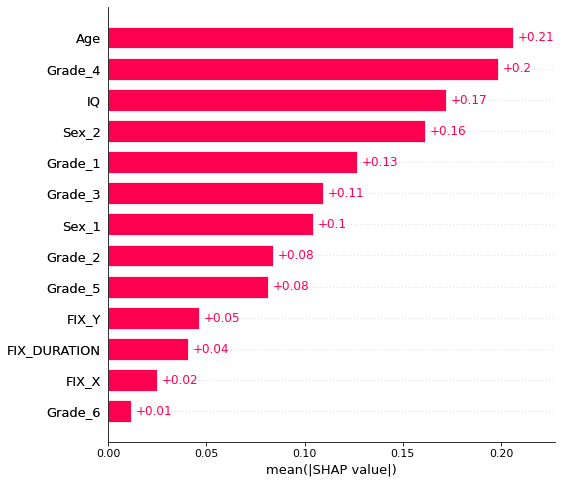

In [95]:


shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")




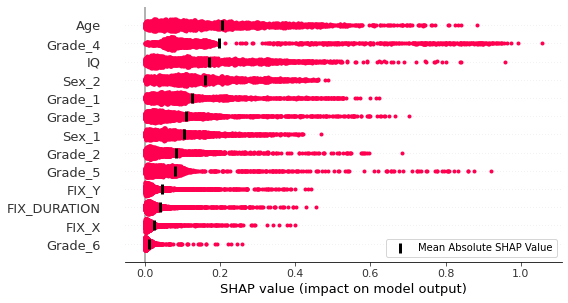

In [96]:




plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")






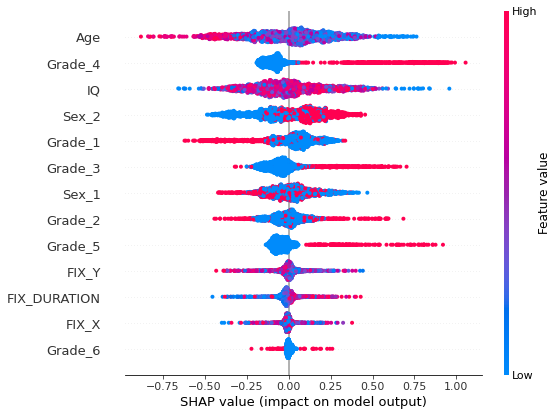

In [97]:


shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )





FixedFormatter should only be used together with FixedLocator


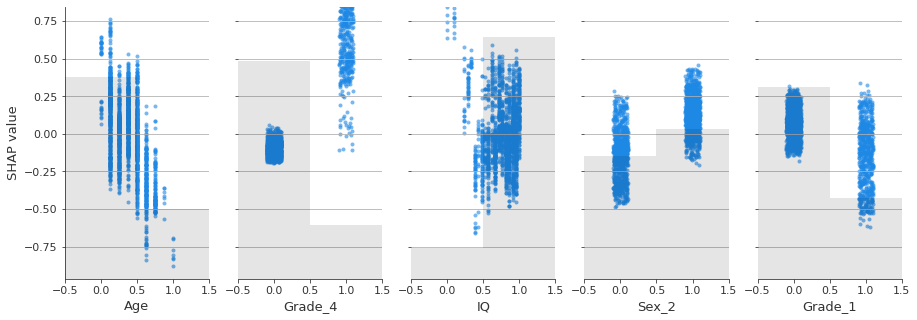

In [98]:

n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")





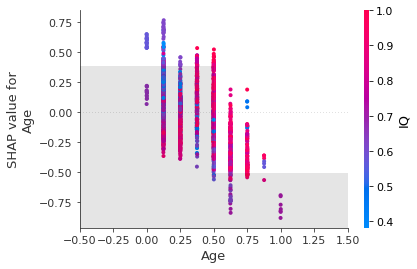

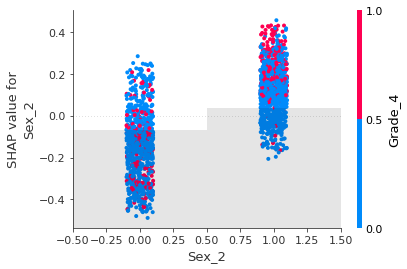

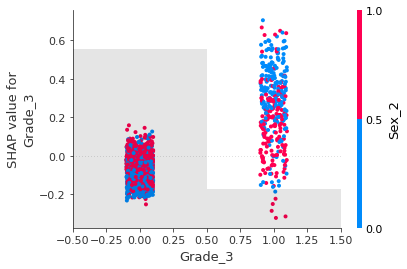

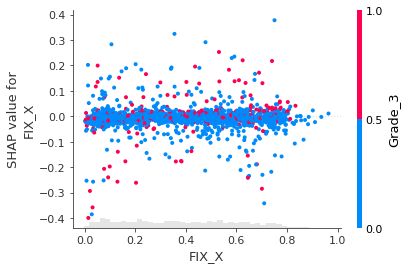

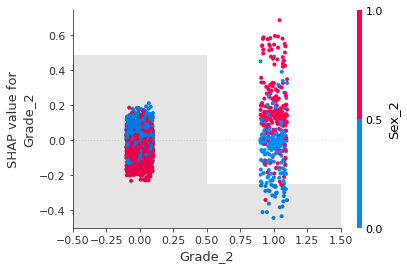

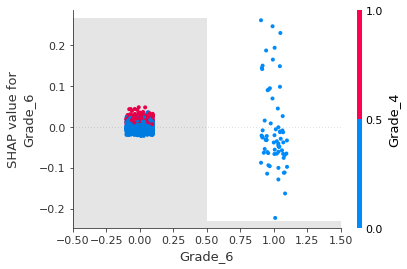

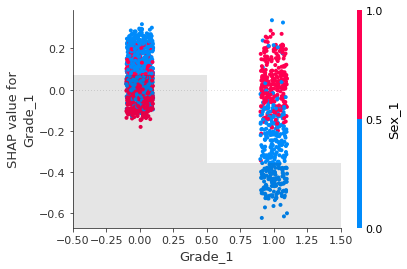

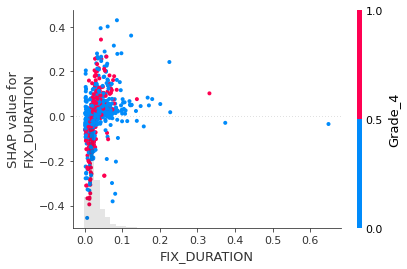

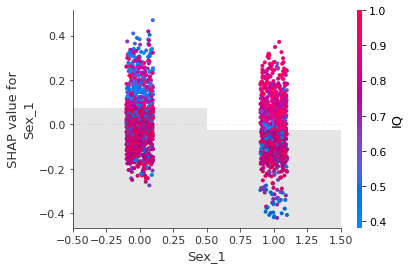

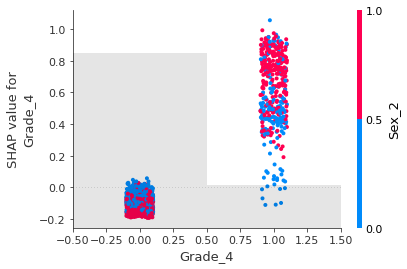

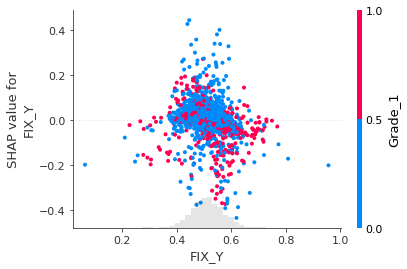

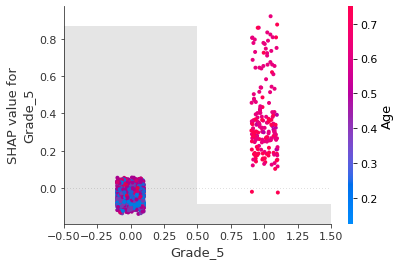

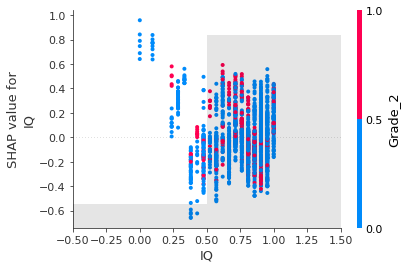

In [99]:


for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)



